# HEART RATE ESTIMATION

Buriola Lorenzo 2021860\
Leonelli Elena 2028635\
Sabatti Alessandra 1237354\
Sartore Marika 2017916

January 2021

The aim of this project is to give an estimation of the __heart rate__ from <ins>SCG</ins> and <ins>BCG</ins> measurements performed with _MuSe_ sensor provided with a three-axes accelerometer, a gyroscope and a magnetometer. 

# Analysis of SCG signal

The SCG data were collected with the sensor placed on the sternum of the subject laying supine.  

In [8]:
#Needed packages
import pandas as pd
import numpy as np

from scipy import signal
import scipy.linalg as la
from scipy.stats import norm
from scipy.integrate import trapz
import math as m
import pywt

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib.gridspec import GridSpec

In [9]:
#colors
colA = 'royalblue'
colG = 'darkorange'
colM = 'brown'

## Load the orginal data

In [10]:
# original dataset
DF = pd.read_csv('center_sternum.txt',sep='\t')  
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


## Select the meaningful data

From the sampling frequency of the dataset (Log Freq = 200 Hz), we obtained the time vector (in seconds) associated to the measurement. 
In order to select only a meaningful time interval for the data, we plotted AccX, GyroX and MagnX as a function of time. 
As we can see from the plot, at the beginning and at the end of the dataset, there are some irregularities, so we cropped it in the interval $[7.5,70]\;s$. Then time was rescaled to bring the first measure to $0\;s$.



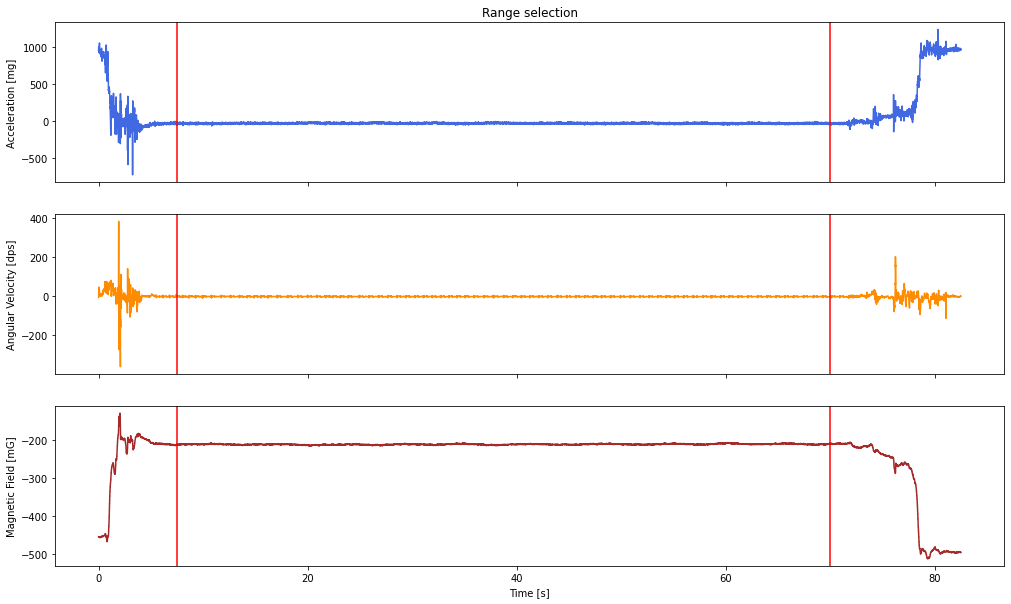

In [11]:
# plot raw data
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'], color=colA)
ax1.axvline(x = 7.5, color = 'red')
ax1.axvline(x = 70, color = 'red')
ax1.set_ylabel('Acceleration [mg]')
ax1.set_title('Range selection')

ax2.plot(t, DF['GyroX'], color=colG)
ax2.axvline(x = 7.5, color = 'red')
ax2.axvline(x = 70, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')

ax3.plot(t, DF['MagnX'], color=colM)
ax3.axvline(x = 7.5, color = 'red')
ax3.axvline(x = 70, color = 'red')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Magnetic Field [mG]') 

plt.show()

The most interesting columns are the ones with the measurements of the instruments accelerometer [mg], gyroscope [dps], and magnetometer [mG], and the corresponding time [s]. Quaternions data were neglected.

In [12]:
# new dataset with only the interesting data
a = 1500
b = 14000
sample_freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1) 
df['Time'] = np.arange(0, len(df['AccX']))/sample_freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-24.949,115.046,-951.661,0.687023,4.870229,1.511450,-212,-434,435,0.000
1501,-10.980,106.323,-971.059,1.358779,3.358779,1.099237,-212,-435,435,0.005
1502,-17.690,109.800,-970.022,1.068702,3.160305,0.702290,-213,-435,434,0.010
1503,-21.533,104.249,-965.630,0.687023,2.793893,0.381679,-213,-435,434,0.015
1504,-23.668,104.737,-967.033,0.305343,2.748092,0.778626,-214,-435,435,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-30.866,118.767,-941.108,-3.175573,3.358779,-0.778626,-210,-430,427,62.480
13997,-32.818,118.279,-942.145,-2.992366,3.679389,-0.549618,-210,-430,427,62.485
13998,-22.692,113.704,-948.184,-3.022901,3.786260,-0.564885,-211,-432,427,62.490
13999,-38.674,119.743,-937.143,-2.854962,3.419847,-0.885496,-211,-432,427,62.495


## Calibration

Here we show the calibration procedure of the dataset, according to data contained in the file "README1.TXT"

In [13]:
# calibration matrices and offset vectors
gyro_off = np.array([-2.242224,2.963463,-0.718397])
acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_off = np.array([-3.929942,-13.74679,60.67546])
magn_cal=np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_off=np.array([-95.67974,-244.9142,17.71132])

In [14]:
# calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-28.504953,100.373720,-894.980558,-1.555201,7.833692,0.793053,-278.962788,-635.189046,395.663599,0.000
1501,-14.488596,91.833874,-914.453062,-0.883445,6.322242,0.380840,-278.939536,-636.103922,395.659342,0.005
1502,-21.213892,95.250842,-913.412547,-1.173522,6.123768,-0.016107,-279.862302,-636.084927,394.781061,0.010
1503,-25.050763,89.820226,-908.991605,-1.555201,5.757356,-0.336718,-279.862302,-636.084927,394.781061,0.015
1504,-27.187979,90.304963,-910.399517,-1.936881,5.711555,0.060229,-280.778107,-636.057418,395.652380,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191,62.480
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191,62.485
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195,62.490
13999,-42.264295,104.980254,-880.401686,-5.097186,6.383310,-1.603893,-278.117853,-633.416605,388.677195,62.495


## Statistical analysis

Mean, median, variance, standard deviation, 25th and 75th percentiles are reported:

In [15]:
# statistical descriptors
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-34.309794,100.734210,-892.685252,-4.328721,6.644769,-1.585265,-278.662436,-633.718653,391.202763
median,-34.260318,100.958415,-893.069606,-4.394896,6.597051,-1.573359,-278.962788,-633.416605,391.286894
variance,49.866401,29.206212,212.532768,2.080482,0.532462,0.145359,1.437342,3.149817,6.780515
standard deviation,7.061615,5.404277,14.578504,1.442388,0.729700,0.381260,1.198892,1.774772,2.603942
25% percentile,-38.950034,97.321571,-901.411472,-4.944514,6.230639,-1.832901,-279.099931,-635.184788,388.689191
75% percentile,-29.601040,104.292364,-884.704283,-3.707873,6.963463,-1.344351,-278.046984,-632.478477,393.907037


We use the mean to center the data. Variance tells which component has bigger variability (this will be important later in the PCA procedure).

### Correlation coefficients

In [16]:
# corr.coeff.
M = df.loc[:,:'MagnZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.175850,-0.406324,0.211097,0.006664,0.027037,-0.380642,-0.022166,0.071081
AccY,-0.175850,1.000000,0.173606,-0.049653,0.000488,-0.103754,0.233688,0.353350,-0.491820
AccZ,-0.406324,0.173606,1.000000,-0.079548,0.117838,0.019098,0.119201,0.202044,-0.247645
GyroX,0.211097,-0.049653,-0.079548,1.000000,0.400553,0.368676,-0.061395,-0.057079,0.024329
GyroY,0.006664,0.000488,0.117838,0.400553,1.000000,0.426017,0.012710,-0.129760,0.021824
GyroZ,0.027037,-0.103754,0.019098,0.368676,0.426017,1.000000,-0.011409,-0.072499,0.012388
MagnX,-0.380642,0.233688,0.119201,-0.061395,0.012710,-0.011409,1.000000,0.216823,-0.307836
MagnY,-0.022166,0.353350,0.202044,-0.057079,-0.129760,-0.072499,0.216823,1.000000,-0.744287
MagnZ,0.071081,-0.491820,-0.247645,0.024329,0.021824,0.012388,-0.307836,-0.744287,1.000000


Correlation coefficients are not very high, probably due to signal intensity, which is not big with respect to signal noise. The most significant correlations are between the directional components of the same instrument.

## Centering the data


In [17]:
# centered dataset
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,5.804840,-0.360490,-2.295306,2.773520,1.188923,2.378318,-0.300352,-1.470393,4.460836,0.000
1501,19.821197,-8.900336,-21.767811,3.445276,-0.322527,1.966105,-0.277100,-2.385269,4.456578,0.005
1502,13.095901,-5.483368,-20.727295,3.155199,-0.521001,1.569158,-1.199866,-2.366275,3.578297,0.010
1503,9.259030,-10.913984,-16.306353,2.773520,-0.887413,1.248547,-1.199866,-2.366275,3.578297,0.015
1504,7.121814,-10.429248,-17.714266,2.391840,-0.933214,1.645494,-2.115670,-2.338766,4.449616,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-0.133915,3.278773,8.298629,-1.089076,-0.322527,0.088242,1.417365,2.108548,-2.513572,62.480
13997,-2.085940,2.807305,7.259567,-0.905869,-0.001917,0.317250,1.417365,2.108548,-2.513572,62.485
13998,8.064710,-1.684520,1.196196,-0.936404,0.104954,0.301983,0.544584,0.302048,-2.525569,62.490
13999,-7.954502,4.246044,12.283566,-0.768465,-0.261459,-0.018628,0.544584,0.302048,-2.525569,62.495


## PCA

Since the measurements of accelerometer, gyroscope and magnetometer are performed along x,y,z-axes, we applied PCA analysis, in order to rotate the dataset and mantain only the components with major variability. We aim to keep the componets where the signal amplitude is greater with respect to the noise.  

In [18]:
N = dfc.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfc[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfc[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

#Magn
U_magn,D_diag_magn,_=la.svd(dfc[['MagnX','MagnY','MagnZ']].T)
avl_magn = np.real_if_close(D_diag_magn)**2/(N-1)
avl_magn_n = avl_magn/avl_magn.sum()

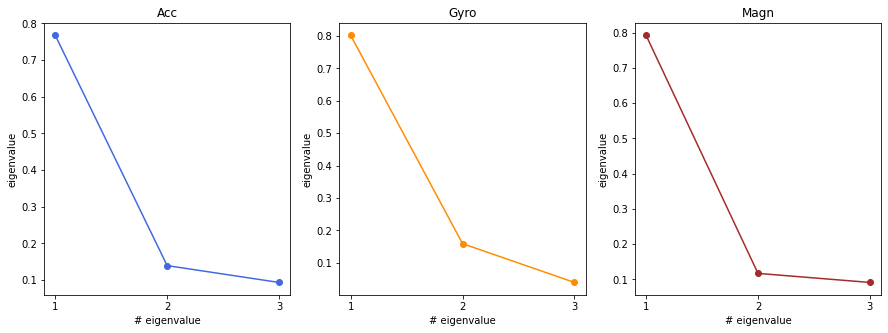

In [19]:
#Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = colA, marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = colG, marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
ax3.plot(np.arange(U_magn.shape[0])+1, avl_magn_n, color = colM, marker = 'o')
ax3.set_title('Magn')
ax3.set_xlabel('# eigenvalue')
ax3.set_ylabel('eigenvalue')
ax3.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

In [20]:
print('Eigenvalues and eigenvectors (Acc): \n', avl_acc, '\n\n',U_acc, '\n')
print('Eigenvalues and eigenvectors (Gyro): \n', avl_gyro, '\n\n',U_gyro, '\n')
print('Eigenvalues and eigenvectors (Magn): \n', avl_magn, '\n\n',U_magn, '\n')

Eigenvalues and eigenvectors (Acc): 
 [223.79621083  40.60562833  27.20354118] 

 [[-0.23593172 -0.93513285 -0.26431569]
 [ 0.07623228  0.25334565 -0.96436747]
 [ 0.96877493 -0.24767426  0.01151503]] 

Eigenvalues and eigenvectors (Gyro): 
 [2.21252496 0.43814605 0.10763217] 

 [[-0.96234803  0.26653218 -0.05335597]
 [-0.2491525  -0.94340978 -0.21886303]
 [-0.10867058 -0.19732864  0.9742957 ]] 

Eigenvalues and eigenvectors (Magn): 
 [9.00334116 1.32824113 1.03609186] 

 [[-0.13892355  0.9203879   0.36549468]
 [-0.5098297  -0.38287722  0.7703757 ]
 [ 0.84898406 -0.07931672  0.52243175]] 



From PCA eigenvectors we can see that the first principal component for the accelerometer is mainly directed along the z-axis, for the gyroscope it is along x, and along z for the magnetometer.
This is in agreement with the orientation of the sensor, whose z-axis is dorso-to-ventral directed, x-axis is foot-to-head directed and y-axis is left-to-right directed. We expect that the most important movements due to the heart beat are orthogonal the sternum.  

We notice that the first principal component contains about $80 \%$ of variability, so in the following analysis we will consider only this one for each instrument.
Thus, data was rotated according to the new axes:

In [21]:
# rotated dataset after PCA
rot = np.dot(dfc[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfc[['GyroX','GyroY','GyroZ']],U_gyro)
rot2 = np.dot(dfc[['MagnX','MagnY','MagnZ']],U_magn)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2],
                    'Magn1': rot2[:,0], 'Magn2': rot2[:,1],'Magn3': rot2[:,2]})

dfr['Time'] = dfc['Time'].values
dfr


,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Magn1,Magn2,Magn3,Time
0,-3.620661,-4.951137,-1.213096,-3.223768,-0.851720,1.908990,4.578555,-0.067279,1.087950,0.000
1,-26.443051,-15.398988,3.093484,-3.448854,0.834583,1.802331,5.038141,0.304745,0.389426,0.005
2,-23.587832,-8.501977,1.587854,-3.077112,1.022839,1.474503,4.411004,-0.482168,-0.392049,0.010
3,-18.813683,-7.384770,7.890016,-2.583671,1.330052,1.262692,4.411004,-0.482168,-0.392049,0.015
4,-19.636443,-4.914679,7.971240,-2.248087,1.193202,1.679825,5.263942,-1.404706,-0.250373,0.020
...,...,...,...,...,...,...,...,...,...,...
12496,8.321046,-1.099466,-3.030988,1.118839,-0.003412,0.214672,-3.405889,0.696579,0.829244,62.480
12497,7.739033,0.863841,-2.072332,0.837763,-0.302238,0.357848,-3.405889,0.696579,0.829244,62.485
12498,-0.872291,-8.264608,-0.493359,0.842180,-0.408187,0.321212,-2.373816,0.585901,-0.887704,62.490
12499,14.100415,5.471909,-1.850801,0.806698,0.045518,0.080076,-2.373816,0.585901,-0.887704,62.495


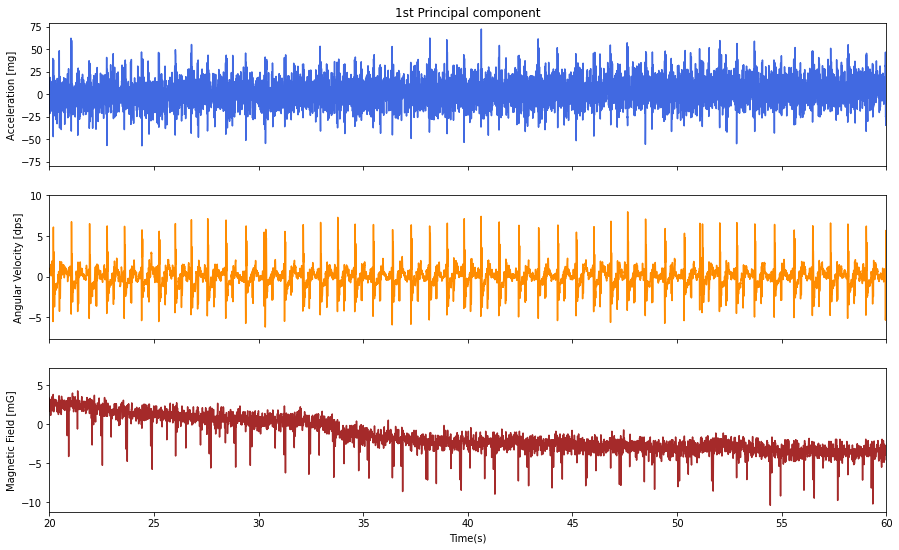

In [22]:
# principal component plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,9),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'],color=colA)
ax[0].set_ylabel('Acceleration [mg]')
ax[0].set_title('1st Principal component')

ax[1].plot(dfr['Time'],dfr['Gyro1'],color=colG)
ax[1].set_ylabel('Angular Velocity [dps]')

ax[2].plot(dfr['Time'],dfr['Magn1'],color=colM)
ax[2].set_ylabel('Magnetic Field [mG]')
ax[2].set_xlim(20,60)
ax[2].set_xlabel('Time(s)')

plt.show()

## FFT analysis

For each principal component, Fast Fourier Transform was calculated in order to highlight the heart-beat frequency in the spectrum, which should be between $[40,100]$ BPM.

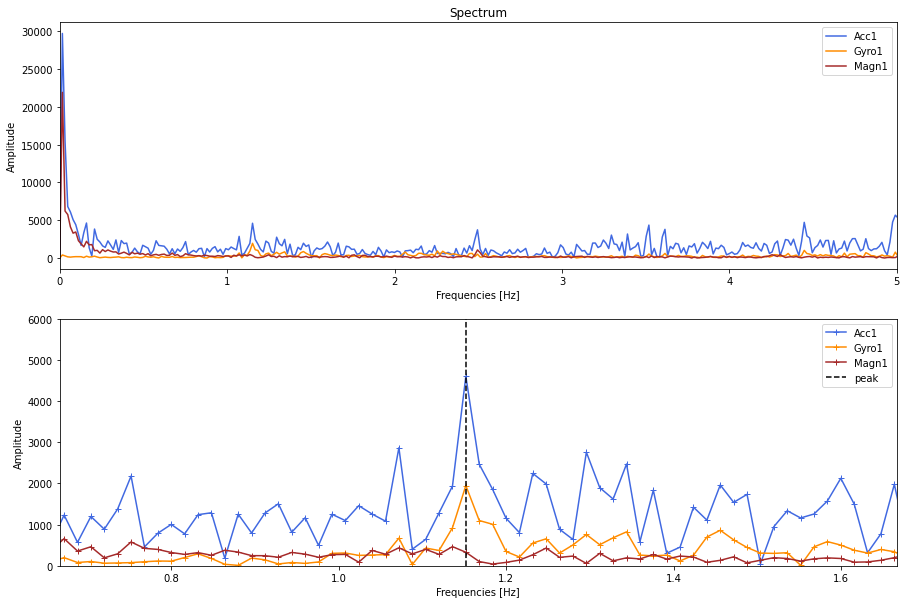

heart beat freq acc = 1.152 +/- 0.009 
heart beat freq gyro = 1.152 +/- 0.009 


In [24]:
# HeartBeat freq
min_f=40./60.
max_f=100./60.

# FFT
A1_FFT = np.abs(np.fft.rfft(dfr['Acc1']))
G1_FFT = np.abs(np.fft.rfft(dfr['Gyro1']))
M1_FFT = np.abs(np.fft.rfft(dfr['Magn1']))
freq_FFT = np.fft.rfftfreq(d=1/sample_freq, n=len(dfr['Acc1']))

X = []
YA = []
YG = []
for i in range(len(A1_FFT)):
    if freq_FFT[i]<=max_f and freq_FFT[i]>=min_f:
        X.append(freq_FFT[i])
        YA.append(A1_FFT[i])
        YG.append(G1_FFT[i])
        
peakA,_ = signal.find_peaks(YA, height=4000)
peakG,_ = signal.find_peaks(YG, height=1500)

# spectrum
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,10))
ax1.plot(freq_FFT, A1_FFT,color=colA, label='Acc1')
ax1.plot(freq_FFT, G1_FFT,color=colG, label='Gyro1')
ax1.plot(freq_FFT, M1_FFT,color=colM, label='Magn1')
ax1.set_xlim(0,5)
ax1.legend(loc='best')
ax1.set_xlabel('Frequencies [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_FFT, A1_FFT,'-+',color=colA, label='Acc1')
ax2.plot(freq_FFT, G1_FFT,'-+',color=colG, label='Gyro1')
ax2.plot(freq_FFT, M1_FFT,'-+',color=colM, label='Magn1')
plt.axvline(x = X[peakG[0]], color='k', linestyle='dashed', label='peak')
ax2.set_xlim(min_f, max_f)
ax2.set_ylim(0,6000)
ax2.legend(loc='best')
ax2.set_xlabel('Frequencies [Hz]')
ax2.set_ylabel('Amplitude')
plt.show()

print('heart beat freq acc = %.3f +/- %.3f ' % (X[peakA[0]] ,0.009))
print('heart beat freq gyro = %.3f +/- %.3f ' % (X[peakG[0]] ,0.009))

We notice that magnetometer does not display any relevant peaks. For the following analysis we will focus on the other instruments.

On their spectra between $[40,100]$ BPM, in fact, it is possible to distinguish a peak that is the same for both accelerometer and gyroscope (with this sampling frequency). This peak is at $1.152 \pm 0.009$ Hz, that corresponds to $69$ BPM. The estimated error is calculated from the sampling frequency interval.

The analysis of this spectrum cannot show anything about heart rate time variations: the presence of multiple peaks around the higher one (which are acceptable heart-beat frequencies as well) suggests us that the heart beat may vary during the acquisition time.

For this reason we decide to make a more accurate analysis, that takes care of both time and frequency.

## Signal Processing

Our aim is to perform a peak analysis on the signal, in order to identify the periodicity of heart beat along time.
For this reason we need to clean the signal and, as far as possible, to highlight the major peaks.

Our first idea was to apply a basic pass-band filter in frequency domain, with a band in physical heart frequencies.
Anyway, the peaks identifying the heart-beat are very fast in time, about $0.05 s$, which corresponds to a frequency of $20$ Hz. But we cannot take the Fourier band this wide, as this would not clean properly the signal, which would remain very noisy.

Our signal processing pipeline was the following:

- Discrete wavelet transform: we used a level 4 DWT and neglected the first detailed coefficients and the approximation coefficients, as each level splits the frequency band into two portions. In this way the selected frequencies are between $[6.25,50]\; Hz$ as required before. For the wavelet analysis we choose to use the wavelet named _'sym4'_ as its shape is similar to our peaks in the signal as shown in the plot below. 
- Signal envelope: to highlight the periodicity of the fast peaks so obtained from the wavelet analysis. It develops low frequencies.  
- Bandpass filter $[0.66, 6]\;Hz$ : filter of the frequency spectrum around relevant frequencies for subsequent analysis. 

For the development of the signal filtering procedure we referred to:

[_Wenyan Jia et al., "Estimation of heart rate from a chest-worn inertial measurement unit", 2015 International Symposium on Bioelectronics and Bioinformatics (ISBB), Beijing, 2015, pp. 148-151, doi: 10.1109/ISBB.2015.7344945._](https://ieeexplore.ieee.org/document/7344945)

[_Yue-Der Lin, Ya-Fen Jhou, "Estimation of heart rate and respiratory rate from the seismocardiogram under resting state
", Biomedical Signal Processing and Control, Volume 57, March 2020, 101779, ISSN 1746-8094._ ](http://www.sciencedirect.com/science/article/pii/S174680941930360X)


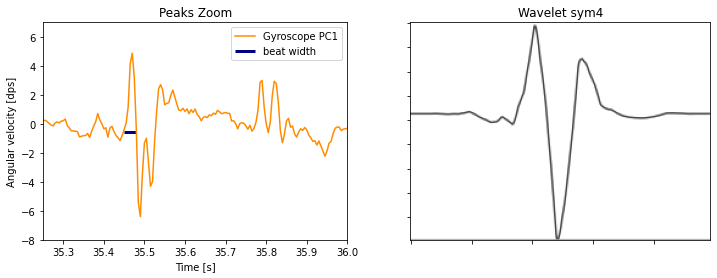

Beat width, example: 0.03 s


In [25]:
#Zoomed plot of a single peak and comparison with the wavelet used
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
ax[0].plot(dfr['Time'],-dfr['Gyro1'],label='Gyroscope PC1',color=colG)
ax[0].set_xlim(35.25,36.0)
ax[0].set_ylim(-8,7)
ax[0].set_ylabel('Angular velocity [dps]')
ax[0].set_xlabel('Time [s]')
ax[0].hlines(-dfr['Gyro1'].values[3544],35.45,35.48,color='navy',linewidth=3,label='beat width')
ax[0].legend()
ax[0].set_title('Peaks Zoom')

import matplotlib.image as mpimg
wavelet = mpimg.imread('sym4_bis.png')
ax[1].imshow(wavelet)
ax[1].axes.xaxis.set_ticklabels([])
ax[1].axes.yaxis.set_ticklabels([])
ax[1].set_title('Wavelet sym4')
plt.show()

print('Beat width, example: 0.03 s')

In [26]:
#Define signal array variable (NOTE: the gyroscope was inverted during the PCA analysis)
sigA = dfr['Acc1']
sigG = -dfr['Gyro1']
t = dfr['Time']

In [27]:
#definition of wavelet decomposition and filtering function
def wavelet_decomposition(t, signal, n, wave_name, color):
    coeff = pywt.wavedec(signal, wave_name, level = n)
    sigs = np.zeros((n+1,len(t)+1))
    for i in range(n+1):
        ca = coeff.copy()
        for j in range(n+1):
            if j != i: 
                ca[j] = np.zeros_like(ca[j])
        sigs[i] = pywt.waverec(ca, wave_name)
    ax = []
    fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
    ax[n].set_xlabel('Time [s]')
    for i in range(n+1):
        ax[i].plot(t, sigs[i][:-1], color = color)
    return coeff

def wavelet_filter(coeff, index, wave_name):
    for j in range(len(coeff)):
        if j not in index: 
            coeff[j] = np.zeros_like(coeff[j])
    sig_w = pywt.waverec(coeff, wave_name)
    return sig_w[:-1]

In [35]:
# bandpass filter
def FILTER(SIG,f1,f2):
    FFT = np.fft.rfft(SIG)
    freq = np.fft.rfftfreq(len(SIG), 1/sample_freq)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = np.fft.irfft(new_FFT, len(SIG))
    return new_SIG


### Gyroscope

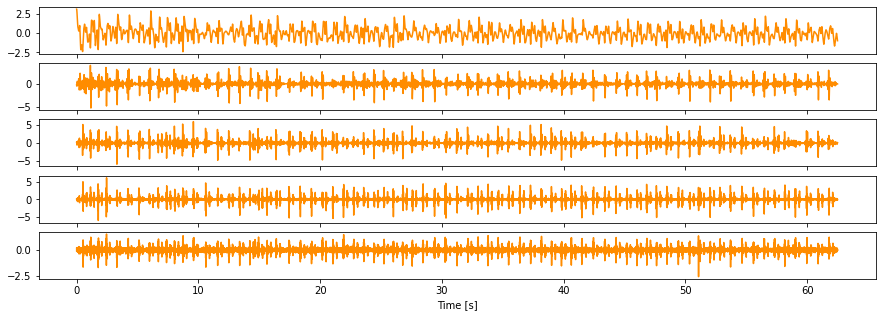

In [36]:
n=4                       #N° of levels for DWT decomposition
wave_name = 'sym4'        #wavelet
CG = wavelet_decomposition(t, sigG, n, wave_name, colG)

In the previous plot, the signals corresponding to each wavelet coefficients are shown. As said before, we will neglect the first (approximation coefficient CA4) and the last one (detailed coefficient CD1).

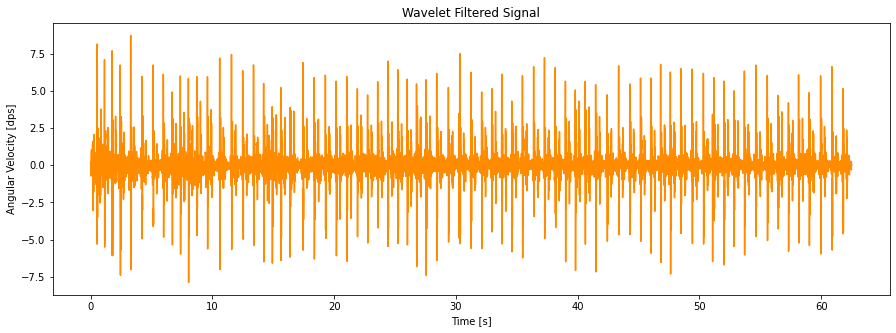

In [37]:
# filtered signal after wavelet decomposition
cg = CG.copy()
SIGG = wavelet_filter(cg, [1,2,3], wave_name)

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, color = colG)
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [dps]')
plt.title('Wavelet Filtered Signal')

plt.show()

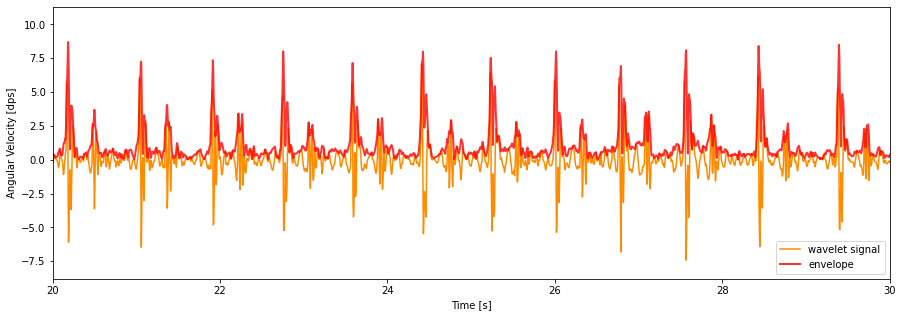

In [38]:
# envelope
SIGG_h = np.abs(signal.hilbert(SIGG))

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, colG,label='wavelet signal')
plt.plot(t, SIGG_h, color = 'r',alpha=0.8, linewidth=2, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')

plt.show()

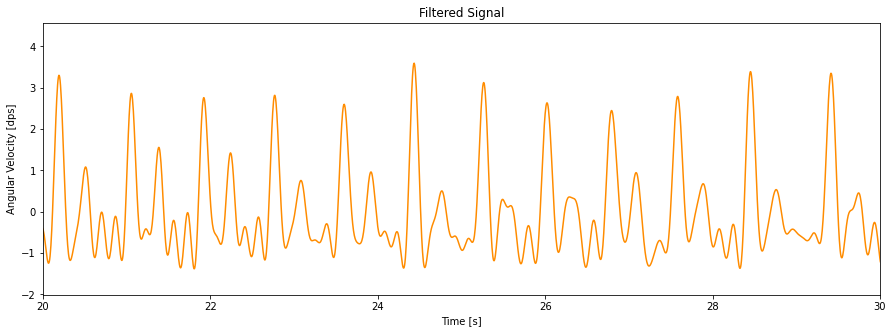

In [39]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_G = FILTER(SIGG_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_G , colG)
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')
plt.show()

### Accelerometer

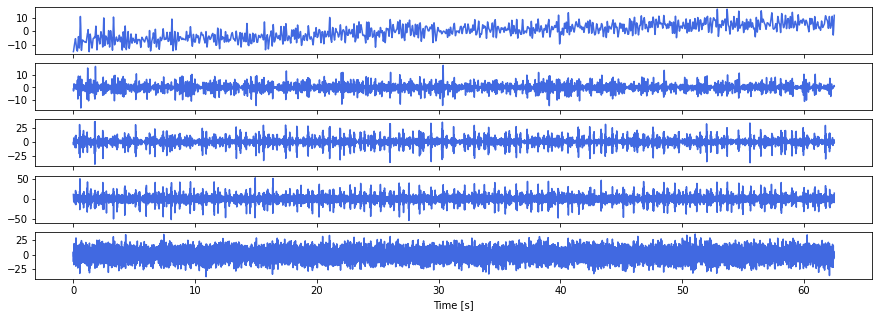

In [40]:
CA = wavelet_decomposition(t, sigA, n, wave_name, colA)

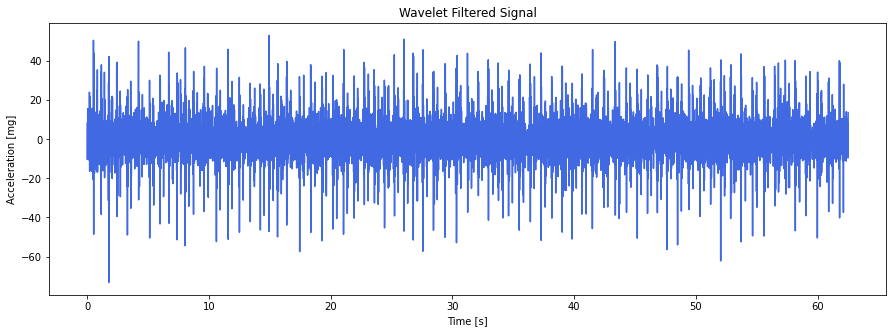

In [41]:
# filtered signal after wavelet decomposition
ca = CA.copy()
SIGA = wavelet_filter(ca, [1,2,3], wave_name)

plt.figure(figsize=(15,5))
plt.plot(t, SIGA, color = colA)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mg]')
plt.title('Wavelet Filtered Signal')
plt.show()

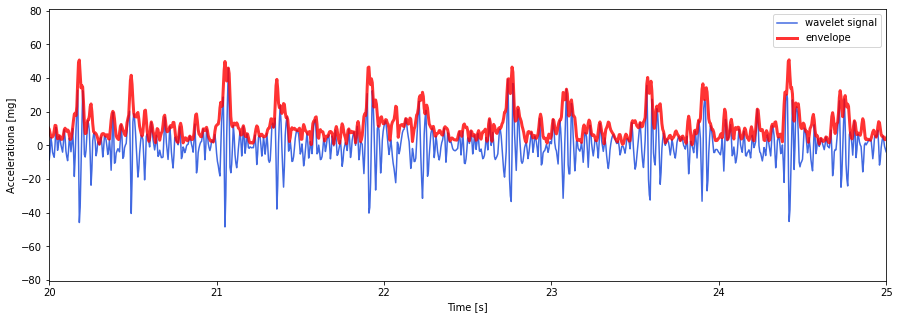

In [42]:
# envelope
SIGA_h = np.abs(signal.hilbert(SIGA))

plt.figure(figsize=(15,5))
plt.plot(t, SIGA, colA, label='wavelet signal')
plt.plot(t, SIGA_h, color ='red', alpha=0.8, linewidth=3, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 25)
plt.ylabel('Accelerationa [mg]')
plt.xlabel('Time [s]')
plt.show()

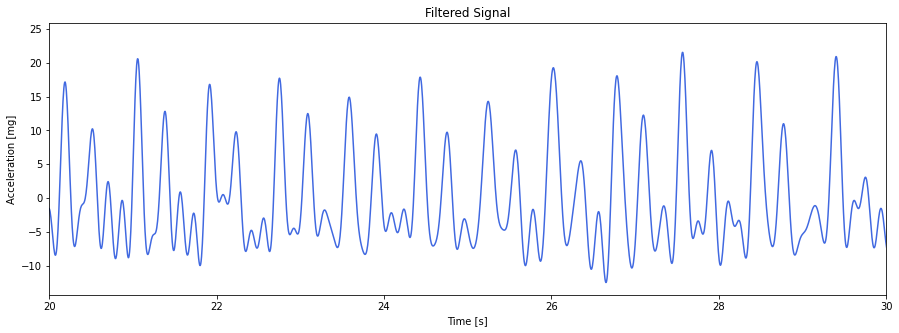

In [43]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_A = FILTER(SIGA_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_A , colA)
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')
plt.show()

Here we show the plot of Fast Fourier Transform of the filtered signals for gyroscope and accelerometer. The filtering procedure mantains the frequency peaks.

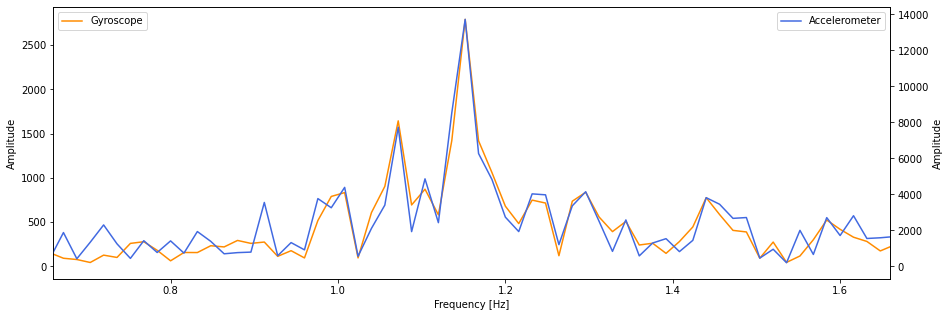

In [44]:
%matplotlib inline
fig,ax1=plt.subplots(figsize=(15,5))
signal_G_fft=np.fft.rfft(signal_G)
freq=np.fft.rfftfreq(d=1/200,n=len(signal_G))
signal_A_fft=np.fft.rfft(signal_A)
freq=np.fft.rfftfreq(d=1/200,n=len(signal_A))
ax1.plot(freq, np.abs(signal_G_fft),color=colG,label='Gyroscope')
ax2=ax1.twinx()
ax2.plot(freq, np.abs(signal_A_fft),color=colA,label='Accelerometer')
ax2.set_xlim(0.66,1.66)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Amplitude')
ax1.set_xlabel('Frequency [Hz]')
plt.show()

## Find peaks

After the filtering, we can proceed analysing the distance between peaks, in order to obtain the plot of HR as a function of time, its histogram and the heart rate variability. 

We use the function __signal.find_peaks__ contained in the __scipy__ library with some tuned parameters (__height__ : minimum height of the peaks and __distance__ : minimum distance from the previous peak). \
We plot the results in a scatterplot and in a histogram.

In [45]:
# function to plot HR vs time and HR histo
def histo_func(bins1,peaks1,t,color,label):
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,marker='o',color=color, label=label)
    ax_main.legend()
    ax_main.set_xlabel('Time [s]')
    ax_main.set_ylabel('Heart rate [BPM]')
    ax_main.set_title('Heart rate as a function of time and histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal',color=color)
    ax_marg.set_xlabel('Freq.')
    bin_center1=(b1[1:]+b1[:-1])*0.5
    ax_marg.set_ylim(l)

### Gyroscope

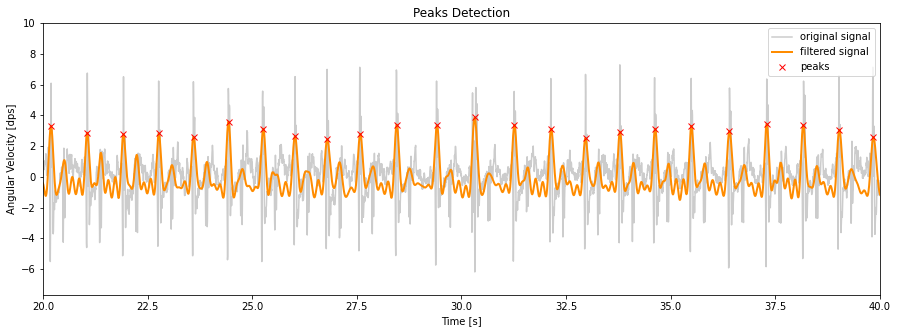

In [46]:
# gyroscope peaks
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(t,-sigG, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_G,label='filtered signal',color=colG, linewidth = 2)
peaksG,_ = signal.find_peaks(signal_G, height=0.3 , distance=100)
plt.plot(t[peaksG],signal_G[peaksG], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')
plt.show()

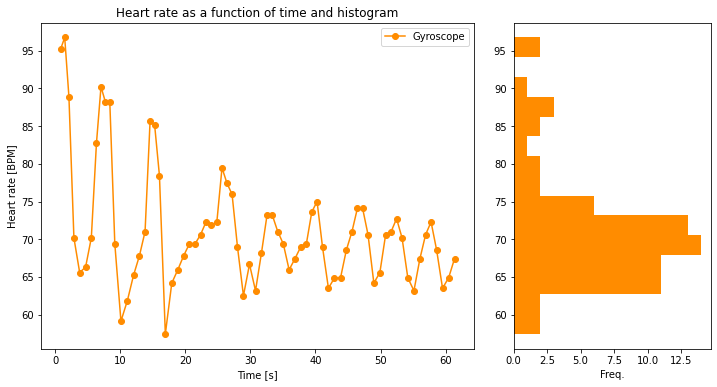

In [47]:
# BPM trend and BPM histo
histo_func(15,peaksG,t.values,colG,'Gyroscope')

### Accelerometer

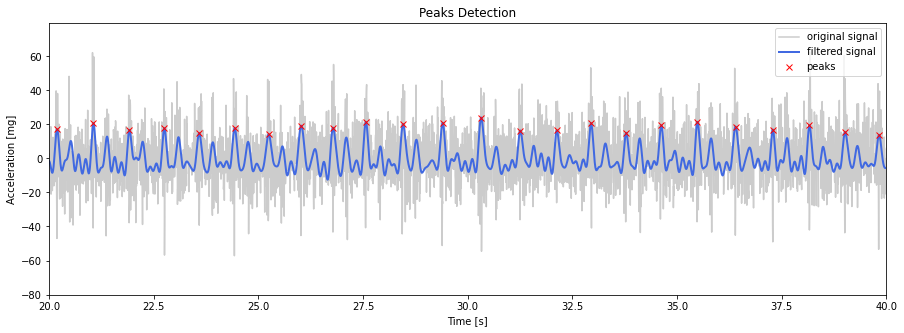

In [48]:
# accelerometer peaks
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(t,sigA, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_A,label='filtered signal',color=colA, linewidth = 2)
peaksA,_ = signal.find_peaks(signal_A, height=4 , distance=122)
plt.plot(t[peaksA],signal_A[peaksA], 'rx', label='peaks')
plt.xlim(20, 40)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')
plt.show()

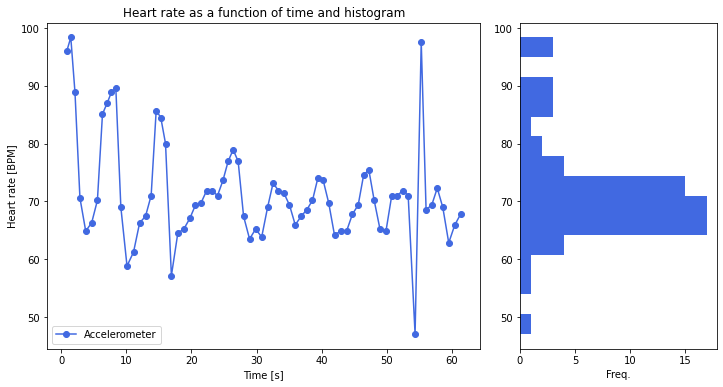

In [49]:
# HRV and BPM histo
histo_func(15,peaksA,t.values,colA,'Accelerometer')

In this case it is clear that __signal.find_peaks__ fails in finding the true peaks around $55\;s$. For this reason we implemented a simple algorithm to fix the position of evident misdetected peaks. This function looks for large differencies in consecutive periods (time intervals between consecutive peaks) and tries to reduce them moving the wrong peak to the nearest maximum.

In [50]:
def single_fix(time,peaks,data,thr, r = 0.5):
    """
    time: array of time
    peaks: array of peaks
    data: array of signal
    thr: vertical threshold above which the peak is not changeable
    r: horizontal range in which the algorithm can move a peak
    """
    peaks_time=time[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    
    peaks_new=peaks.copy()
    diff_mean=np.mean(np.abs(period[1:]-period[:-1]))  #check parameter for modification condition
    for i in np.arange(1,len(period)-1):               #cycle on all peaks

        peaks_time=time[peaks_new]
        period = peaks_time[1:]-peaks_time[:-1]    
        to_check=np.abs(period[i]-period[i+1])

        if to_check>1.5*(diff_mean):
            if period[i]-period[i+1]>0 and data[peaks_new[i+1]] < thr:                 #Subsequent period decrease case
                array=data[(time<time[peaks_new[i+1]]) & (time>time[peaks_new[i+1]]-r)]  
                der = array[1:]-array[:-1]                                             #derivative of the signal data
                change=[]
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0: change=np.append(change,d+1)           #simple maximum condition
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1]-len(array)+change[-1]
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:                             #Check the improvment of solution
                    peaks_new[i+1]= peaks[i+1]
                
            elif period[i]-period[i+1]<0 and data[peaks_new[i+1]] < thr:                #Subsequent period increase case
                array=data[(time>time[peaks_new[i+1]]) & (time<time[peaks_new[i+1]]+r)]
                der = array[1:]-array[:-1]
                change=np.array([])
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1] + change[0] +1
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]
    return peaks_new

#Implemented iteration possibility of the function
def fix_peaks(time,peaks,data,thr,r,iteration,color,ylabel):   
    peaks0 = peaks
    for j in range(iteration):
        peaks_new = single_fix(time,peaks,data,thr, r = 0.5)
        if all(peaks == peaks_new):
            print('fix_peaks exited after %s iterations' %j)
            break
        peaks = peaks_new

    plt.figure(figsize=(15,4))
    plt.plot(time,data,color=color)
    #plt.plot(time,sigA,color='grey',alpha=0.5)
    plt.plot(time[peaks0],data[peaks0], 'rx', label='old peaks')
    plt.plot(time[peaks_new],data[peaks_new], 'gx', label='new peaks')
    plt.xlabel('Time [s]')
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    return peaks_new

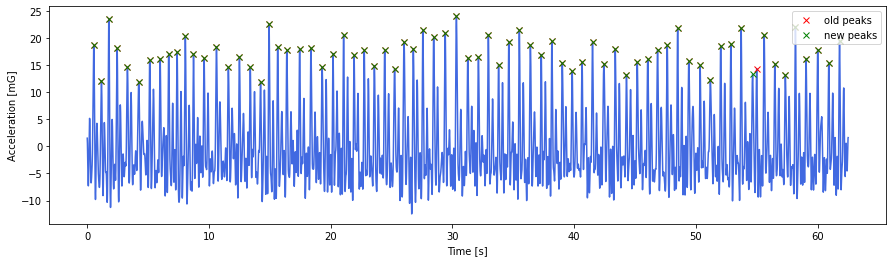

In [51]:
peaks_new_A = fix_peaks(t.values, peaksA, signal_A, thr=16, r=0.5, iteration=1, color=colA, ylabel='Acceleration [mG]')

Here the fixed peaks are plotted.

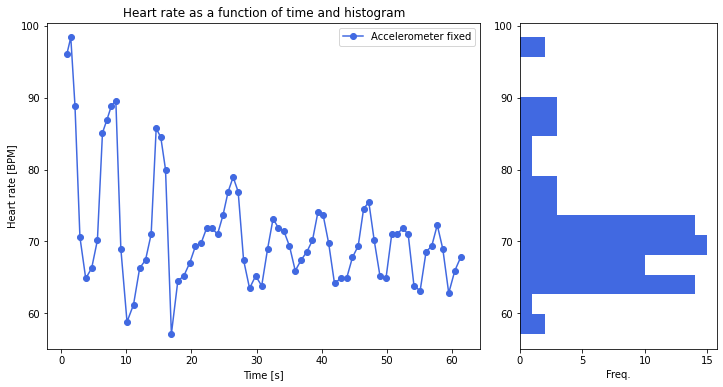

In [52]:
histo_func(15,peaks_new_A,t.values,colA,'Accelerometer fixed')

### Comparison between the two instruments results

In order to visualize the position of the peaks in the two signals, we plot them together to verify their coherence.

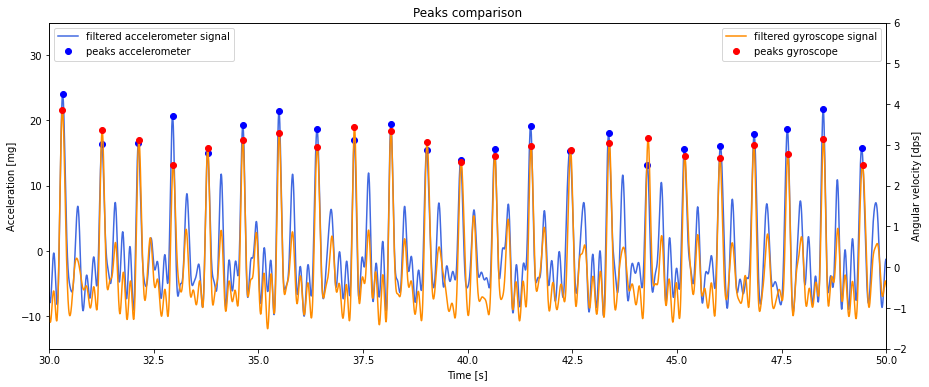

N° of peaks found from gyroscope signal: 73 
N° of peaks found from accelerometer signal: 73


In [53]:
fig,ax1=plt.subplots(figsize=(15,6))

ax1.plot(t,signal_A,label='filtered accelerometer signal',color=colA)
ax1.plot(t[peaks_new_A],signal_A[peaks_new_A], 'bo', label='peaks accelerometer')
ax1.tick_params(axis='y')
ax1.set_ylim(-15,35)

ax2=ax1.twinx()

ax2.plot(t,signal_G,label='filtered gyroscope signal',color=colG)
ax2.plot(t[peaksG],signal_G[peaksG], 'ro', label='peaks gyroscope')
ax2.tick_params(axis='y')
ax2.set_ylim(-2,6)

ax1.set_ylabel('Acceleration [mg]')
ax2.set_ylabel('Angular velocity [dps]')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(30, 50)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Peaks comparison')

plt.show()

print('N° of peaks found from gyroscope signal: %s \nN° of peaks found from accelerometer signal: %s' %(len(peaksG),len(peaksA)))

We can see that the number of peaks found by the algorithm is the same for the two signals and they are mostly at the same time. In the following cell we print the number of beats occurring in one minute. 

In [54]:
#number of heart beats in one minute
print('N° beats in one minute gyroscope: %.2f' %((len(peaksG)-1)/(t.values[peaksG[-1]]-t.values[peaksG[0]])*60))
print('N° beats in one minute accelerometer: %.2f' %((len(peaks_new_A)-1)/(t.values[peaks_new_A[-1]]-t.values[peaks_new_A[0]])*60))

N° beats in one minute gyroscope: 70.51
N° beats in one minute accelerometer: 70.53


## Peaks errors

In order to associate an error to each peak, we decide to obtain it from the FWHM. This one is computed using __signal.peak_widths__ from __scipy__ .  

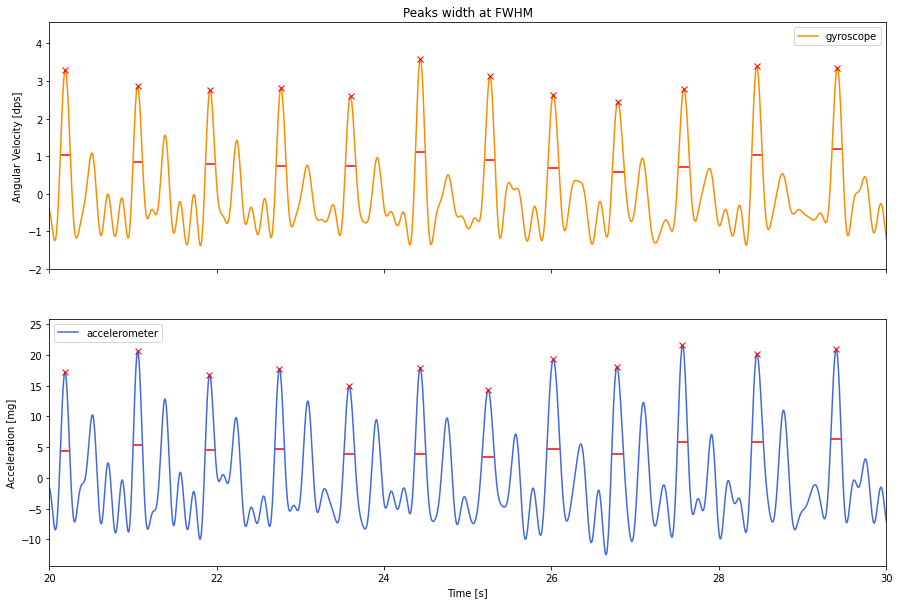

In [55]:
# gyroscope
widthsG = signal.peak_widths(signal_G, peaksG, rel_height=0.5)
# accelerometer
widthsA = signal.peak_widths(signal_A, peaks_new_A, rel_height=0.5)

fig, ax = plt.subplots(2,1, figsize=(15,10),sharex=True)
ax[0].plot(t.values,signal_G,label='gyroscope',color=colG)
ax[0].plot(t.values[peaksG], signal_G[peaksG],'rx')
ax[0].hlines(widthsG[1],xmin=1/sample_freq*widthsG[2],xmax=1/sample_freq*widthsG[3],color='red')
ax[0].set_ylabel('Angular Velocity [dps]')
ax[0].set_title('Peaks width at FWHM')
ax[0].legend()

ax[1].plot(t.values,signal_A,label='accelerometer',color=colA)
ax[1].plot(t.values[peaksA], signal_A[peaksA],'rx')
ax[1].hlines(widthsA[1],xmin=1/sample_freq*widthsA[2],xmax=1/sample_freq*widthsA[3],color='red')
ax[1].set_xlim(20, 30)
ax[1].set_ylabel('Acceleration [mg]')
ax[1].set_xlabel('Time [s]')
ax[1].legend()

plt.show()

In the following cells we define two functions that will be used for the result section.

In [56]:
#heart rate variability calculation function
def hrv(time,peaks,widths):
    
    const = 2*(2*np.log(2))**0.5
    sigma = widths[0]/const*1/sample_freq
    
    peaks_time = time[peaks]
    period=peaks_time[1:]-peaks_time[:-1]
    sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
    period_diff=np.abs(period[1:]-period[:-1])
    sigma_period_diff=(sigma_period[1:]**2 + sigma_period[:-1]**2)**0.5
        
    hrv= np.mean(period_diff**2)**0.5
    hrv2=hrv**2
    N=len(peaks)
    sigma_hrv2=(np.sum((2*period_diff*sigma_period_diff)**2))**0.5/(N-2)
    sigma_hrv = 0.5/hrv*sigma_hrv2
   
    return hrv, sigma_hrv

In [57]:
#Function for computing the KDE using the errors found
def kde_func(widths,time,peaks):
    const = 2*(2*np.log(2))**0.5
    sigma = widths[0]/const*1/sample_freq

    peaks_time=np.array(time.values[peaks])

    period = peaks_time[1:] - peaks_time[:-1]
    sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
    rate = 1/period*60
    err_rate = rate/period*sigma_period

    #KDE 
    xx = np.linspace(min(rate),max(rate),1000)
    fx = np.zeros(xx.shape)
    for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
        fx += norm.pdf(xx,r,s)
    fx = fx/trapz(fx,xx)
    return xx,fx,rate,err_rate

xxG,fxG,rateG,err_rateG = kde_func(widthsG,t,peaksG)
xxA,fxA,rateA,err_rateA = kde_func(widthsA,t,peaks_new_A)

## Results

In the following cells we report the results of the analysis on the SCG signal. 

Firstly we plot the heart rate as a function of time, extracted from the two instruments datasets, during the acquisition time. We associated to each point the error previoulsy calculated. \
Then the __histograms of the HR__ obtained from the peaks analysis are shown. The KDE is also plotted to give an idea of the trend. Note that, as said before, the KDE was computed using the rates errors. \
Finally, we give an estimation of the __Heart rate variability__ for this dataset.

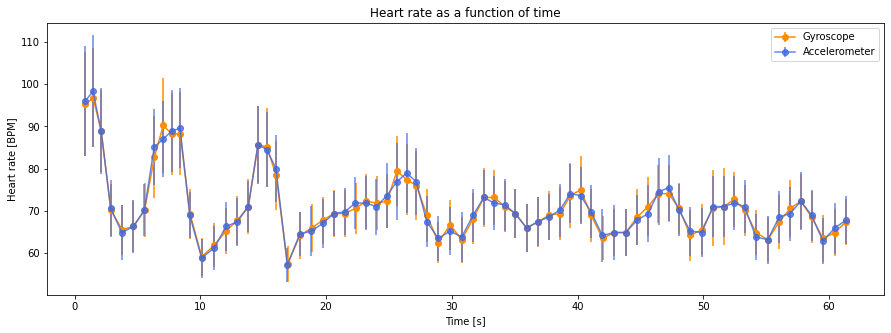

In [58]:
plt.figure(figsize=(15,5))
plt.errorbar((t.values[peaksG][1:]+t.values[peaksG][:-1])*0.5,rateG,err_rateG,marker='o',color=colG,label='Gyroscope')
plt.errorbar((t.values[peaks_new_A][1:]+t.values[peaks_new_A][:-1])*0.5,rateA,err_rateA,marker='o',color=colA,label='Accelerometer',alpha=0.8)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Heart rate [BPM]')
plt.title('Heart rate as a function of time')
plt.show()

The temporal trend of the heart rate measured from the two instruments (gyroscope and accelerometer) is the same. Both of them highlight the presence of natural oscillations in time of the HR of the subject. Notice that the HR values are mainly between $60$ and $80$ BPM, with a bigger amplitude in the oscillations in the first $15\;s$

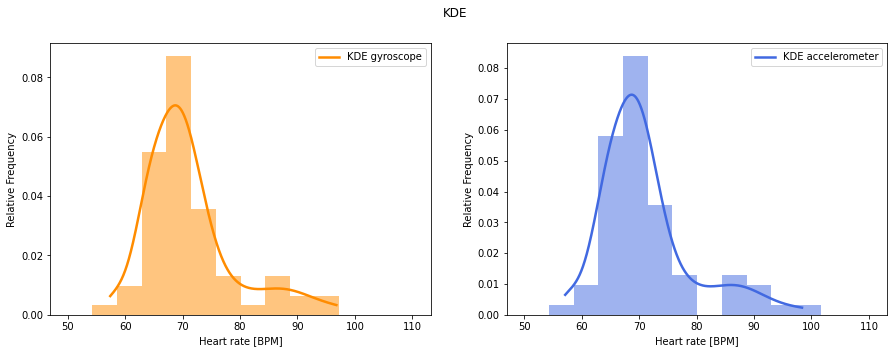

In [59]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

bins=np.arange(50,111,4.3)
ax[0].hist(rateG, bins=bins, density=True, alpha=0.5, color=colG)
ax[0].plot(xxG, fxG, linewidth=2.5, linestyle='solid',color=colG,label='KDE gyroscope')
ax[0].set_xlabel('Heart rate [BPM]')
ax[0].set_ylabel('Relative Frequency')
ax[0].legend()
ax[1].hist(rateA, bins=bins, density=True, alpha=0.5, color=colA)
ax[1].plot(xxA, fxA, linewidth=2.5, linestyle='solid',color=colA,label='KDE accelerometer')
ax[1].set_xlabel('Heart rate [BPM]')
ax[1].set_ylabel('Relative Frequency')
ax[1].legend()
fig.suptitle('KDE')
plt.show()

From the histograms, we can see that heart rate values are peaked around $70$ BPM with a tail in the higher values due to the earlier rate values (see above).
We cannot give an estimation of the distribution because the dataset is not large enough, for more precise statistics on the distribution we would need a longer time of acquisition (way longer than one minute). 

We choose as a final estimation of the HR the weighted mean of the rates. As the temporal trend suggests, we know that this estimator does not totally describe the data sample. The values computed from the two instruments perfectly agree ($\lambda = 0.1$).

In [60]:
#HR mean with weights
meanG = np.average(rateG, weights=1/err_rateG**2)
meanA=np.average(rateA,weights=1/err_rateA**2)
err_meanA = (1/np.sum(1/err_rateA**2))**0.5
err_meanG = (1/np.sum(1/err_rateG**2))**0.5

print('HR gyroscope: %.1f +/- %.1f BPM' %(meanG, err_meanG))
print('HR accelerometer: %.1f +/- %.1f BPM' %(meanA, err_meanA))

HR gyroscope: 68.7 +/- 0.7 BPM
HR accelerometer: 68.8 +/- 0.7 BPM


We estimate __heart rate variability__ with RMSSD method (Root Mean Square of Successive Differences) applied to heart beat periods, where a heart beat period is the difference in time between two consecutive peaks.
This parameter is important because it tells how heart period varies from one beat to the following. This can also be found in the HR vs time plot, which shows different values of successive rates.

In [61]:
#Heart rate variability
hrv_A, sigma_hrv_A = hrv(t.values,peaks_new_A,widthsA)
hrv_G, sigma_hrv_G = hrv(t.values,peaksG,widthsG)

print('Heart rate variability for accelerometer: %.0f +/- %.0f ms' %(hrv_A*1000, sigma_hrv_A*1000))
print('Heart rate variability for gyroscope: %.0f +/- %.0f ms' %(hrv_G*1000, sigma_hrv_G*1000))

Heart rate variability for accelerometer: 71 +/- 13 ms
Heart rate variability for gyroscope: 69 +/- 13 ms


The two values are compatible ($\lambda = 0.1$), but this is also due to a probable overestimation of the errors of the HRV that comes from the uncertainties on peak positions.

# Analysis of BCG signal

Now we perform the same analysis on a BCG signal. Data were taken with the sensor located on the chest attached to the sweater of the subject (4_Chest_sweater.txt).

## Load the original data

In [62]:
# original dataset
DF = pd.read_csv('4_Chest_sweater.txt',sep='\t')
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790


## Select the meaningful data

We proceed as the previous dataset, noticing that the sample frequency of the dataset is Log Freq = 100 Hz. The interval in time we selected is $[10,140]\;s$.

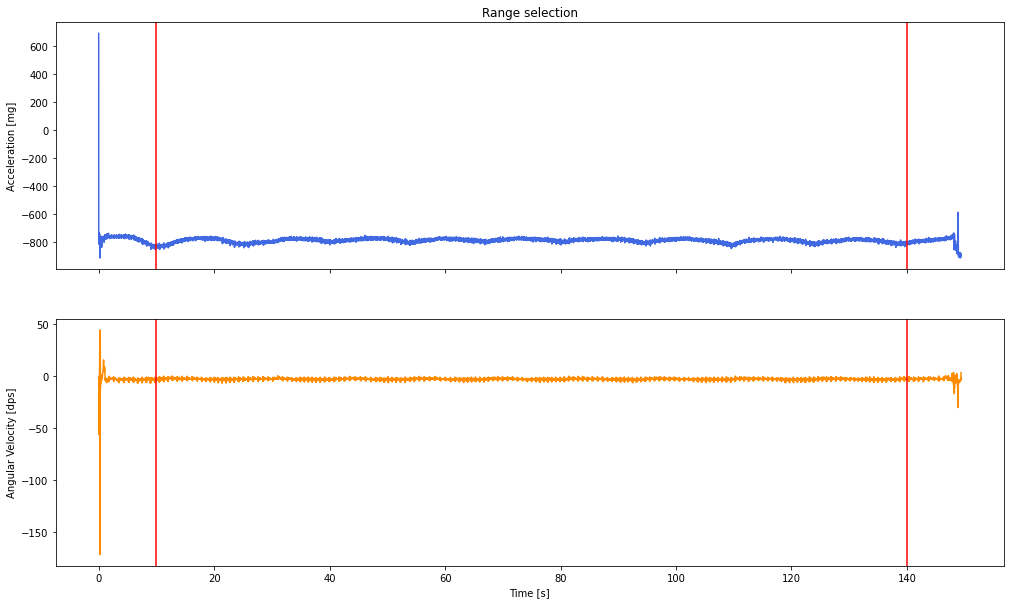

In [64]:
# plot raw data
(fig, (ax1,ax2)) = plt.subplots(2,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'],color=colA)
ax1.axvline(x = 10, color = 'red')
ax1.axvline(x = 140, color = 'red')
ax1.set_ylabel('Acceleration [mg]')
ax1.set_title('Range selection')

ax2.plot(t, DF['GyroX'],color=colG)
ax2.axvline(x = 10, color = 'red')
ax2.axvline(x = 140, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')
ax2.set_xlabel('Time [s]')

plt.show()

As we saw in the previous analysis of SCG dataset, the measurements of accelerometer and gyroscope better describe the system; thus we consider only this two sets for the analysis.

In [65]:
# new dataset with only the interesting data
a = 1000
b = 14000
sample_freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk','MagnX','MagnY','MagnZ'], axis=1) 
df['Time'] = np.arange(0, len(df['AccX']))/sample_freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-822.219,-105.957,579.012,-1.829268,0.609756,0.609756,0.00
1001,-818.498,-111.386,577.731,-2.682927,0.731707,0.731707,0.01
1002,-827.587,-108.214,577.670,-4.512195,0.609756,0.731707,0.02
1003,-829.600,-110.105,570.594,-3.536585,1.463415,0.731707,0.03
1004,-833.260,-108.824,563.701,-2.195122,1.341463,0.609756,0.04
...,...,...,...,...,...,...,...
13996,-807.213,-78.019,617.259,-2.682927,0.609756,0.365854,129.96
13997,-803.980,-72.041,616.344,-2.682927,1.219512,0.609756,129.97
13998,-803.065,-78.934,597.068,-2.804878,1.097561,0.243902,129.98
13999,-802.211,-79.788,614.697,-2.682927,1.829268,0.243902,129.99


## Calibration

In [66]:
# calibration matrices and offset vectors
gyro_off = np.array([-2.804399, 1.793105, 0.3411708])
acc_cal = np.array([[1.002982, 9.415505E-05, 0.004346743],
                    [9.04459E-05, 1.002731, -0.001444198], 
                    [0.004346536, -0.001444751,	1.030587]])
acc_off = np.array([3.602701, -20.96658, 54.97186])

In [67]:
# calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-818.561316,-128.123523,648.273377,-4.633667,2.402861,0.950927,0.00
1001,-814.835299,-133.565163,646.977212,-5.487326,2.524812,1.072878,0.01
1002,-823.951369,-130.385234,646.870258,-7.316594,2.402861,1.072878,0.02
1003,-826.001308,-132.271361,639.571807,-6.340984,3.256520,1.072878,0.03
1004,-829.702063,-130.977239,632.450211,-4.999521,3.134568,0.950927,0.04
...,...,...,...,...,...,...,...
13996,-803.341688,-100.163103,687.715099,-5.487326,2.402861,0.707024,129.96
13997,-800.102461,-94.167163,686.777527,-5.487326,3.012617,0.950927,129.97
13998,-799.269170,-101.051067,666.925868,-5.609277,2.890666,0.585073,129.98
13999,-798.336075,-101.932782,685.099032,-5.487326,3.622373,0.585073,129.99


## Statistical analysis

Mean, median, variance, standard deviation, 25th and 75th percentiles are reported:

In [68]:
# statistical descriptors
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
mean,-782.610405,-94.627886,707.983191,-5.620871,3.297117,0.622097
median,-780.100191,-94.335121,711.157509,-5.609277,3.256520,0.585073
variance,198.130373,180.768600,491.788827,0.641299,0.901328,0.056764
standard deviation,14.075879,13.445021,22.176312,0.800812,0.949383,0.238252
25% percentile,-791.461692,-103.978008,694.757991,-5.975131,2.646764,0.463122
75% percentile,-772.174827,-84.323690,723.607053,-5.121472,3.866276,0.828976


### Correlation coefficients

In [69]:
# corr.coeff.
M = df.loc[:,:'GyroZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
AccX,1.000000,0.728544,0.721530,-0.039568,0.051239,0.009302
AccY,0.728544,1.000000,0.718113,-0.029258,0.045958,-0.029860
AccZ,0.721530,0.718113,1.000000,-0.034282,0.008241,-0.031668
GyroX,-0.039568,-0.029258,-0.034282,1.000000,-0.524570,0.489724
GyroY,0.051239,0.045958,0.008241,-0.524570,1.000000,-0.548018
GyroZ,0.009302,-0.029860,-0.031668,0.489724,-0.548018,1.000000


With respect to the previous dataset, the correlation coefficients among the components of the same instrument are more relevant. This is probably due to the oscillation we can see in the following plot.

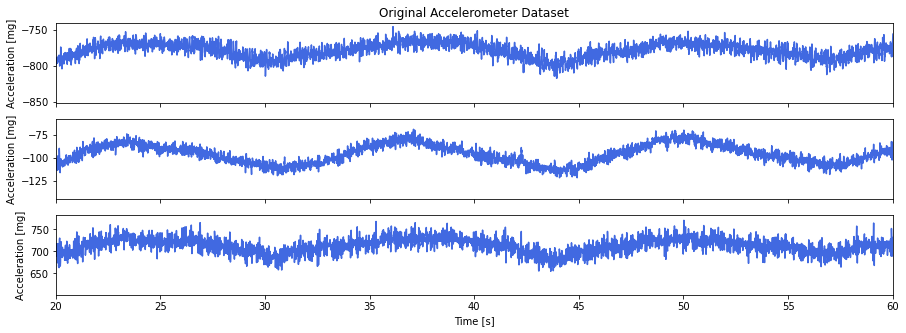

In [70]:
# principal component plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,5),sharex=True)
ax[0].plot(df['Time'],df['AccX'],color=colA)
ax[0].set_ylabel('Acceleration [mg]')

ax[0].set_title('Original Accelerometer Dataset')

ax[1].plot(df['Time'],df['AccY'],color=colA)
ax[1].set_ylabel('Acceleration [mg]')
ax[2].plot(df['Time'],df['AccZ'],color=colA)
ax[2].set_ylabel('Acceleration [mg]')

ax[2].set_xlim(20,60)
ax[2].set_xlabel('Time [s]')

plt.show()

We can see that the same oscillation is present in all the components of the accelerometer and gyroscope, with a period around $15\;s$. For this reason the components correlations are more relevant, and this affects also the variability of the dataset. To avoid the PCA to be influenced by this issue, after centering the data, we use a filter to remove this low frequencies component.

## Centering the data

In [73]:
# centered dataset
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-35.950911,-33.495636,-59.709814,0.987204,-0.894256,0.328830,0.00
1001,-32.224895,-38.937276,-61.005979,0.133545,-0.772305,0.450781,0.01
1002,-41.340965,-35.757348,-61.112933,-1.695723,-0.894256,0.450781,0.02
1003,-43.390903,-37.643475,-68.411384,-0.720113,-0.040597,0.450781,0.03
1004,-47.091659,-36.349353,-75.532980,0.621350,-0.162549,0.328830,0.04
...,...,...,...,...,...,...,...
13996,-20.731283,-5.535217,-20.268092,0.133545,-0.894256,0.084928,129.96
13997,-17.492057,0.460723,-21.205664,0.133545,-0.284500,0.328830,129.97
13998,-16.658765,-6.423181,-41.057323,0.011594,-0.406451,-0.037023,129.98
13999,-15.725670,-7.304895,-22.884159,0.133545,0.325256,-0.037023,129.99


In [75]:
#filtering low frequencies (cut-off frequency=0.1)
Sig = dfc.values[:,:-1].T
n_Sig = np.zeros_like(Sig)
for i in range(Sig.shape[0]):
    ft = np.fft.rfft(Sig[i])
    f = np.fft.rfftfreq(len(Sig[i]), 1/sample_freq)
    ft[f < 0.1] = 0
    n_Sig[i] = np.fft.irfft(ft, len(Sig[i]))

dfn = pd.DataFrame(n_Sig.T, columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'])

After this filter we recalculated the variance and the correlation coefficients, and we can see that they have decreased, as we expected.

In [78]:
# variance
stat_dfn = pd.DataFrame({'variance': dfn.var()}).T
stat_dfn

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
variance,54.602597,20.949014,187.926273,0.524324,0.69157,0.049929


In [79]:
# correlation coefficients
M = dfn.loc[:,:'GyroZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
AccX,1.000000,0.294988,0.172427,0.009658,0.014608,0.050421
AccY,0.294988,1.000000,0.303391,0.076325,0.015768,-0.002925
AccZ,0.172427,0.303391,1.000000,0.022885,-0.070615,-0.019341
GyroX,0.009658,0.076325,0.022885,1.000000,-0.411272,0.406293
GyroY,0.014608,0.015768,-0.070615,-0.411272,1.000000,-0.470671
GyroZ,0.050421,-0.002925,-0.019341,0.406293,-0.470671,1.000000


## PCA

In [81]:
N = dfn.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfn[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfn[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

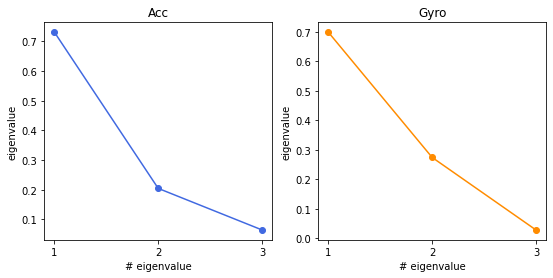

In [82]:
#Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = colA, marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = colG, marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

In [83]:
print('Eigenvalues and eigenvectors (Acc): \n', avl_acc, '\n\n',U_acc, '\n')
print('Eigenvalues and eigenvectors (Gyro): \n', avl_gyro, '\n\n',U_gyro, '\n')

Eigenvalues and eigenvectors (Acc): 
 [192.54927235  53.90214694  17.02646402] 

 [[-0.13307117  0.96680284  0.21813832]
 [-0.11691521  0.20324628 -0.97212231]
 [-0.98418641 -0.15486514  0.08598773]] 

Eigenvalues and eigenvectors (Gyro): 
 [0.8836895  0.34657325 0.03555983] 

 [[-0.57865026 -0.81143569 -0.08207317]
 [ 0.80513527 -0.58439334  0.10120093]
 [-0.13008106 -0.00752007  0.99147484]] 



From PCA we can see that the first principal component is mostly along z-axis for the accelerometer, for gyroscope along y-axis.

We notice that the first principal component contains about $70 \%$ of variability, so in the following analysis we will consider only this one for each instrument.
Thus, data were rotated accordingly to the new axes:

In [84]:
# rotated dataset after PCA
rot = np.dot(dfn[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfn[['GyroX','GyroY','GyroZ']],U_gyro)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2]})
dfr['Time'] = df['Time'].values
dfr

,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Time
0,15.491248,-5.080693,7.154127,-0.892206,-0.347657,0.184328,0.00
1,16.870863,-2.368021,13.107089,-0.312097,0.272442,0.387695,0.01
2,17.781577,-10.503280,7.979827,0.652035,1.827638,0.525539,0.02
3,25.422653,-11.723227,8.700495,0.778619,0.536716,0.531909,0.03
4,32.738114,-13.920504,5.984763,-0.076136,-0.480014,0.288608,0.04
...,...,...,...,...,...,...,...
12996,-28.430115,9.125879,-13.122464,-0.385621,0.348900,0.012301,129.96
12997,-28.678783,13.638517,-18.364018,0.077415,-0.009679,0.315886,129.97
12998,-8.485874,16.136148,-13.235909,0.101210,0.162888,-0.049128,129.98
12999,-26.430925,14.061175,-10.651135,0.623588,-0.364079,0.014966,129.99


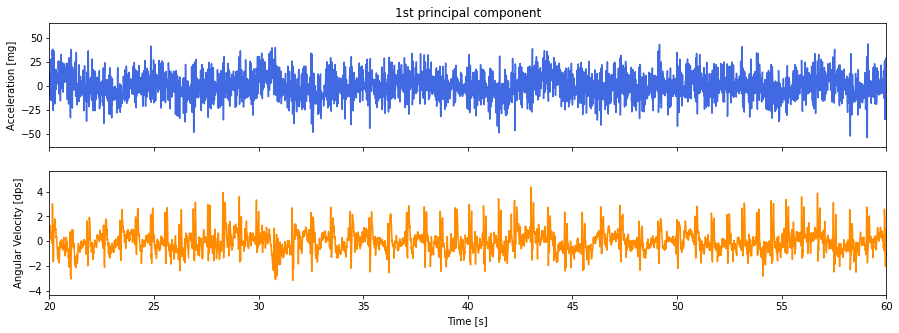

In [87]:
# principal component plots
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,5),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'],color=colA)
ax[0].set_ylabel('Acceleration [mg]')
ax[0].set_title('1st principal component')
ax[1].plot(dfr['Time'],dfr['Gyro1'],color=colG)
ax[1].set_ylabel('Angular Velocity [dps]')


ax[1].set_xlim(20,60)
ax[1].set_xlabel('Time [s]')

plt.show()

## FFT analysis

For each principal component, we performed the FFT to highlight the heart beat frequency between 40 BPM and 100 BPM.

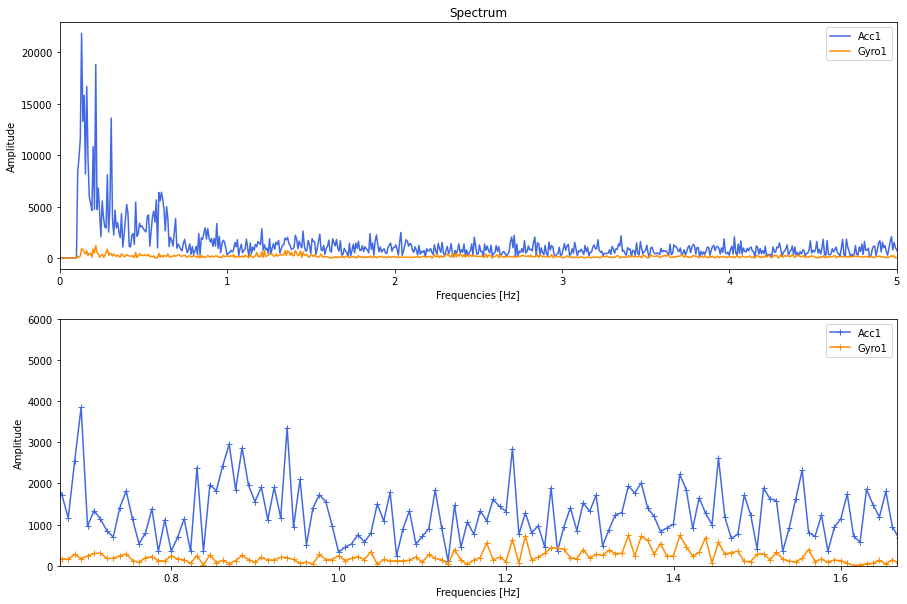

In [88]:
# HeartBeat freq
min_f=40./60.
max_f=100./60.

# FFT
A1_FFT = np.abs(np.fft.rfft(dfr['Acc1']))
G1_FFT = np.abs(np.fft.rfft(dfr['Gyro1']))
freq_FFT = np.fft.rfftfreq(d=1/sample_freq, n=len(dfr['Acc1']))

# spectrum
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,10))
ax1.plot(freq_FFT, A1_FFT, label='Acc1',color=colA)
ax1.plot(freq_FFT, G1_FFT, label='Gyro1',color=colG)
ax1.set_xlim(0,5)
ax1.legend(loc='best')
ax1.set_xlabel('Frequencies [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_FFT, A1_FFT,'-+', label='Acc1',color=colA)
ax2.plot(freq_FFT, G1_FFT,'-+', label='Gyro1',color=colG)
ax2.set_xlim(min_f, max_f)
ax2.set_ylim(0,6000)
ax2.legend(loc='best')
ax2.set_xlabel('Frequencies [Hz]')
ax2.set_ylabel('Amplitude')

plt.show()

In this case applying the pure FFT does not give a clear result. The spectrum does not display any particular frequency peak that can suggest the right heart beat, in both gyroscope and accelerometer. We need to proceed with the analysis, in order to extract results from this dataset.

## Signal Processing

As before, our signal processing pipeline is the following:

- Discrete wavelet transform: in this case a $3$ level DWT was performed and only the detailed coefficients corresponding to a band of $[6.25, 25]\;Hz$ are kept. We have changed the upper frequency limit with respect to the previous analysis because this signal is way more noisy and the wavelet corresponding to $[25, 50] \;Hz$ worsens the quality of the signal. The wavelet chosen is 'sym4'.
- Signal envelope
- Bandpass filter $[0.66, 6]\;Hz$ 


In [98]:
#Define signal array variable
sigA = -dfr['Acc1']
sigG = dfr['Gyro1']
t = dfr['Time']

 ### Gyroscope

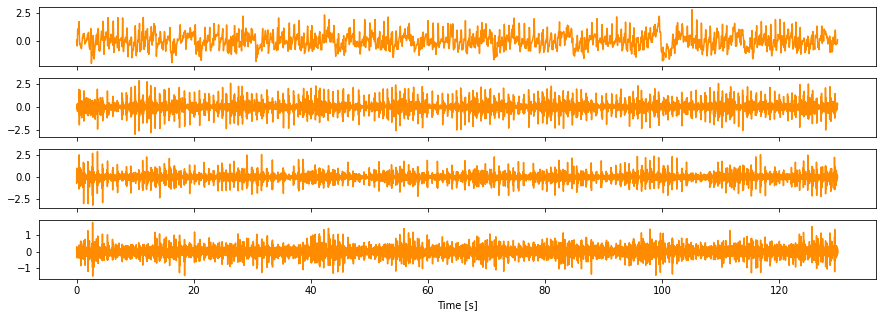

In [99]:
n=3  #N° of levels fot DWT decomposition
wave_name='sym4' #wavelet
CG = wavelet_decomposition(t, sigG, n, wave_name ,color=colG)

In the previous plot, the signals corresponding to each wavelet coefficients are shown. As said before, we will neglect the first (approximation coefficient CA4) and the last one (detailed coefficient CD1).

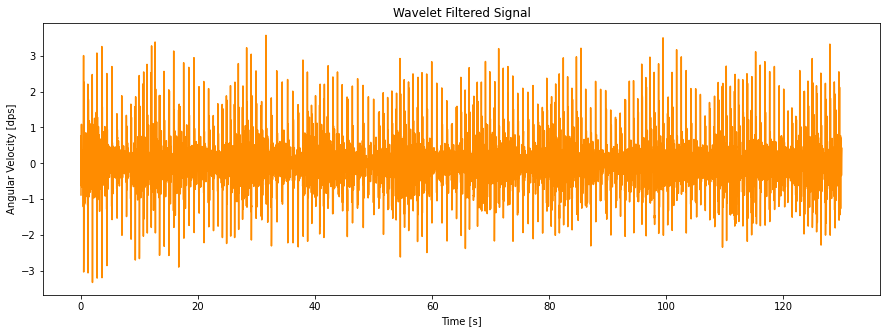

In [100]:
# filtered signal after wavelet decomposition
cg = CG.copy()
SIGG = wavelet_filter(cg, [1,2], wave_name)

plt.figure(figsize=(15,5))
plt.plot(t, SIGG,color=colG)
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [dps]')
plt.title('Wavelet Filtered Signal')

plt.show()

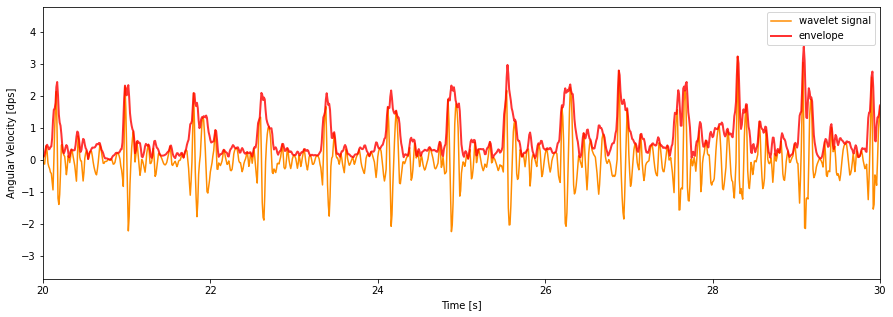

In [101]:
# envelope
SIGG_h = np.abs(signal.hilbert(SIGG))

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, color=colG, label='wavelet signal')
plt.plot(t, SIGG_h, color = 'red',alpha=0.8, linewidth=2, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.show()

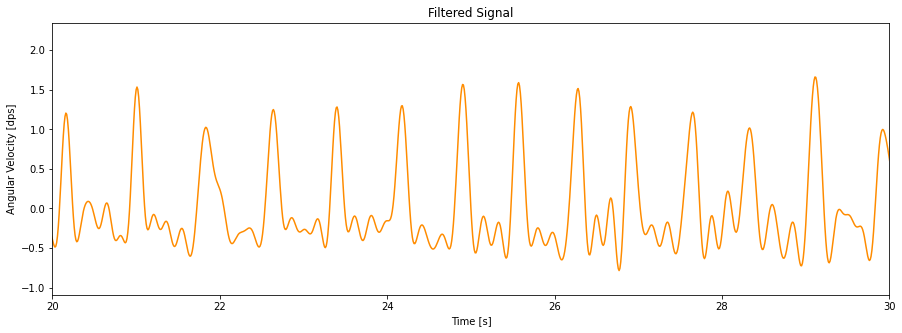

In [102]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_G = FILTER(SIGG_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_G ,color=colG)
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')
plt.show()

### Accelerometer

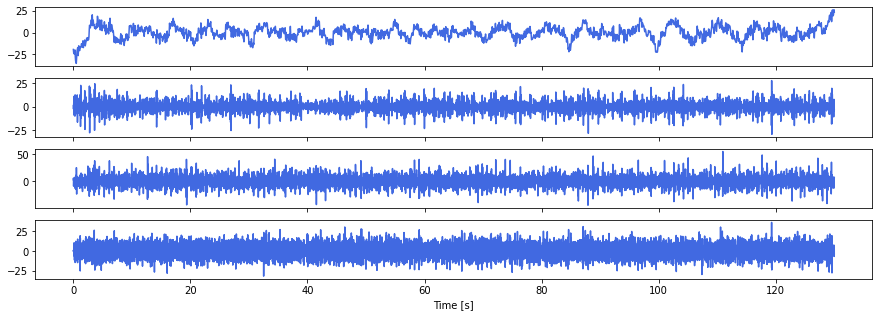

In [103]:
CA = wavelet_decomposition(t, sigA, n, wave_name,color=colA)

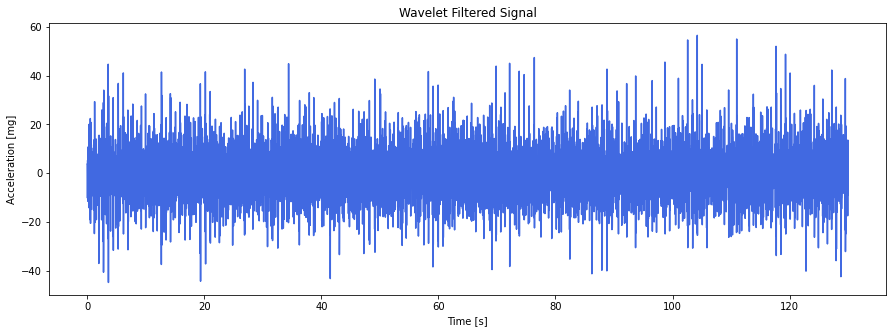

In [104]:
# filtered signal after wavelet decomposition
ca = CA.copy()
SIGA = wavelet_filter(ca, [1,2], wave_name)

plt.figure(figsize=(15,5))
plt.plot(t, SIGA,color=colA)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mg]')
plt.title('Wavelet Filtered Signal')
plt.show()

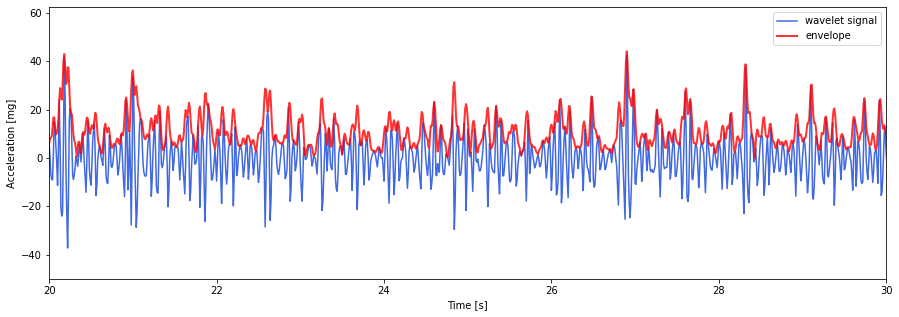

In [105]:
# envelope
SIGA_h = np.abs(signal.hilbert((SIGA)))

plt.figure(figsize=(15,5))
plt.plot(t, SIGA,color=colA, label='wavelet signal')
plt.plot(t, SIGA_h, color = 'r',alpha=0.8, linewidth=2, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.show()

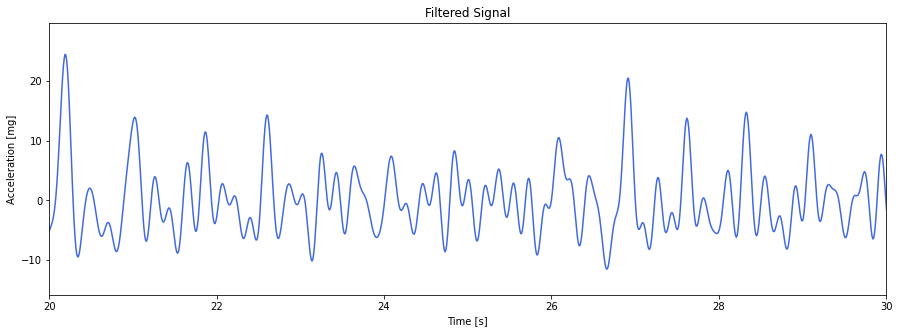

In [106]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_A = FILTER(SIGA_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_A ,color=colA)
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')
plt.show()

Here we show the plot of Fast Fourier Transform of the filtered signals for gyroscope and accelerometer. The filtering procedure higlights the frequency peaks between $[1,1.6]\;Hz$.

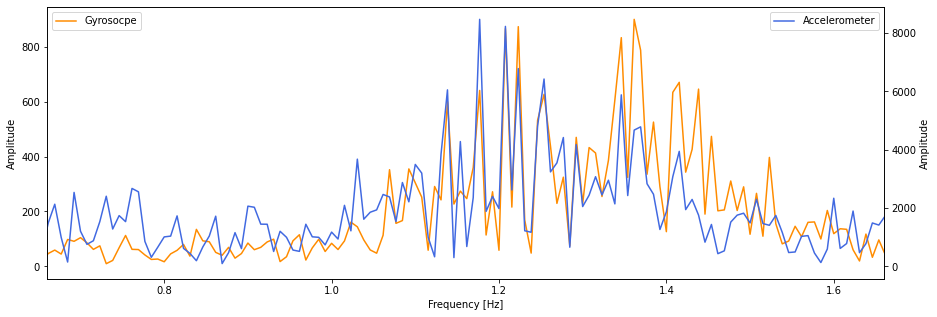

In [110]:
%matplotlib inline
fig,ax1=plt.subplots(figsize=(15,5))
signal_G_fft=np.fft.rfft(signal_G)
freq=np.fft.rfftfreq(d=1/sample_freq,n=len(signal_G))
signal_A_fft=np.fft.rfft(signal_A)
freq=np.fft.rfftfreq(d=1/sample_freq,n=len(signal_A))
ax1.plot(freq, np.abs(signal_G_fft),color=colG,label='Gyrosocpe')
ax2=ax1.twinx()
ax2.plot(freq, np.abs(signal_A_fft),color=colA,label='Accelerometer')
ax2.set_xlim(0.66,1.66)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Amplitude')
ax1.set_xlabel('Frequency [Hz]')
plt.show()

## Find peaks

As in the previous analysis, we perform a peak analysis on the filtered data with __find_peaks__. When it fails the peaks are fixed with the function __fix_peaks__ mentioned before.

### Gyroscope

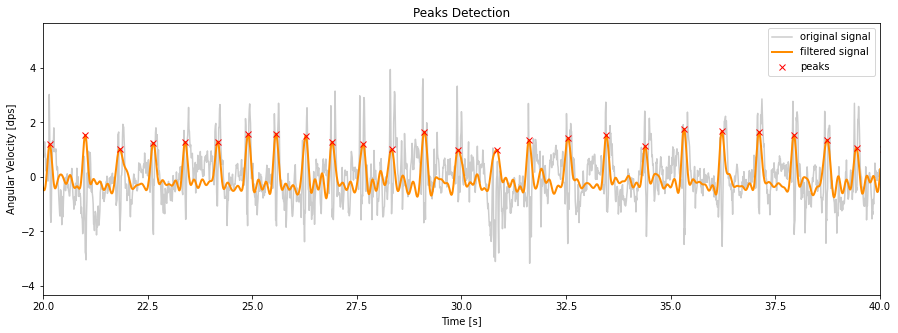

In [111]:
plt.figure(figsize=(15,5))
plt.plot(t,sigG, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_G,label='filtered signal',color=colG,linewidth=2)
peaksG,_ = signal.find_peaks(signal_G, height=0.3 , distance=50)
plt.plot(t[peaksG],signal_G[peaksG], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')
plt.show()

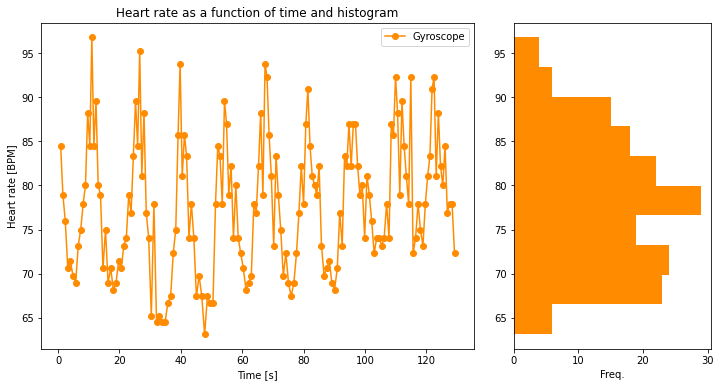

In [113]:
# HR as a function of time and HR histo
histo_func(10,peaksG,t.values,color=colG,label='Gyroscope')

### Accelerometer

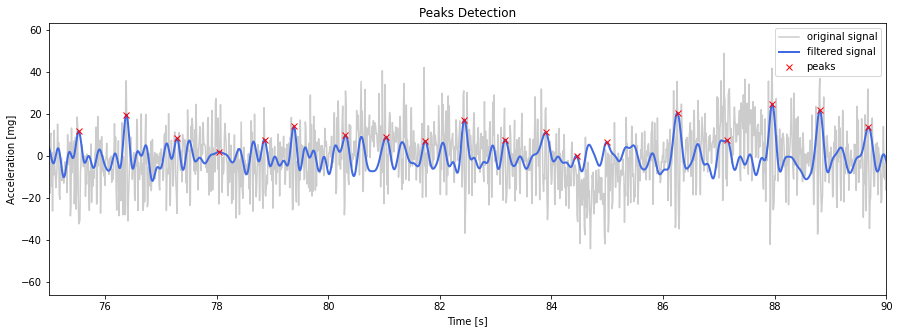

In [114]:
plt.figure(figsize=(15,5))
plt.plot(t,sigA, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_A,label='filtered signal',color=colA,linewidth=2)
peaksA,_ = signal.find_peaks(signal_A, height=-5 , distance=52)
plt.plot(t[peaksA],signal_A[peaksA], 'rx', label='peaks')
plt.xlim(75,90)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')
plt.show()

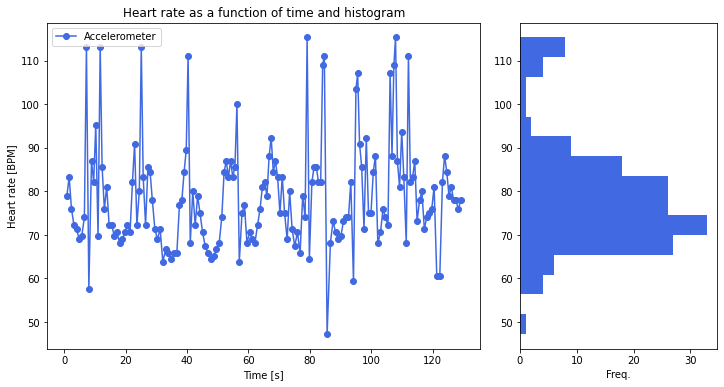

In [116]:
# HR as a function of time and HR histo
histo_func(15,peaksA,t.values,color=colA,label='Accelerometer')

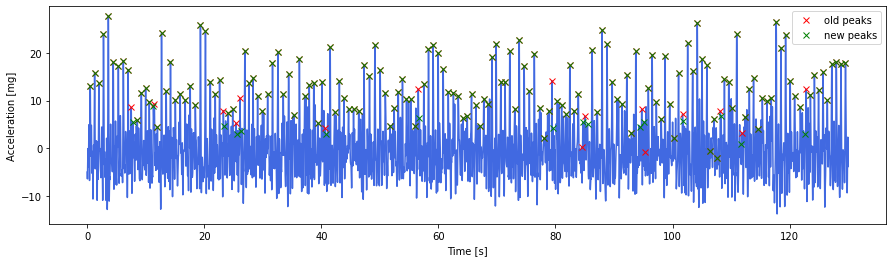

In [117]:
# fixed peaks for the accelerometer
peaks_new_A = fix_peaks(t.values,peaksA,signal_A,thr=15,r=0.4, iteration = 3,color=colA,ylabel='Acceleration [mg]')

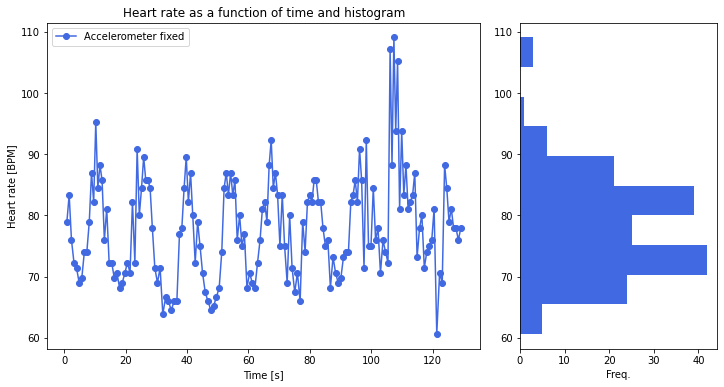

In [118]:
histo_func(10,peaks_new_A,t.values,color=colA,label='Accelerometer fixed')

In the case of accelerometer, the function __fix_peaks__ manages to fix the peaks up to $100 \; s$. In the last $40 \; s$ some mistakes appears. They are probably due to the fact that around $110\; s$ the __find_peaks__ algorithm finds an additional peak (with respect to the ones detected with the gyroscope) and at $120 \; s$ it loses one peak. This causes some irregularities that our function cannot fix.

### Comparison between the two instruments


Also in this case we proceed with the comparison between the two signal peaks detection.

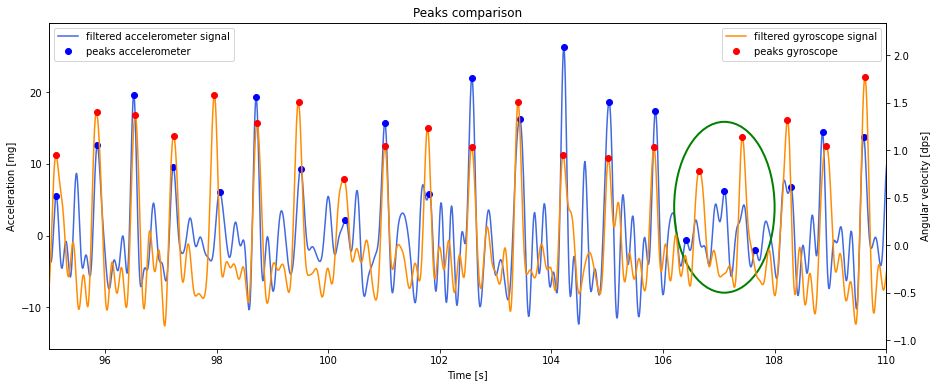

N° of peaks found from gyroscope signal: 167 
N° of peaks found from accelerometer signal: 167


In [119]:
from matplotlib.patches import Circle
fig,ax1=plt.subplots(figsize=(15,6))


ax1.plot(t,signal_A,label='filtered accelerometer signal',color=colA)
ax1.plot(t[peaks_new_A],signal_A[peaks_new_A], 'bo', label='peaks accelerometer')
ax1.tick_params(axis='y')
ax2=ax1.twinx()
ax2.plot(t,signal_G,label='filtered gyroscope signal',color=colG)
ax2.plot(t[peaksG],signal_G[peaksG], 'ro', label='peaks gyroscope')
ax2.tick_params(axis='y')
ax1.set_ylabel('Acceleration [mg]')
ax2.set_ylabel('Angular velocity [dps]')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(95, 110)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Peaks comparison')

circ = Circle((107.1, 0.4), 0.9, fc = 'None', ec = 'green', alpha = 1, lw = 2)
ax2.add_patch(circ)

plt.show()

print('N° of peaks found from gyroscope signal: %s \nN° of peaks found from accelerometer signal: %s' %(len(peaksG),len(peaksA)))

As we underlined before, although the number of points is the same, there are some regions where the peaks do not coincide (see green circle). 

In the next cell we print the number of beats within a minute extracted from data.

In [121]:
#number of heart beats in one minute
print('N° beats in one minute gyroscope: %.2f' %((len(peaksG)-1)/(t.values[peaksG[-1]]-t.values[peaksG[0]])*60))
print('N° beats in one minute accelerometer: %.2f' %((len(peaks_new_A)-1)/(t.values[peaks_new_A[-1]]-t.values[peaks_new_A[0]])*60))

N° beats in one minute gyroscope: 77.15
N° beats in one minute accelerometer: 77.19


## Peaks errors

The errors of the peaks for the BCG signal are overall greater than the previous ones because the peaks are less defined and larger. Notice that in the case of accelerometer some peaks are smaller because of the noise. 

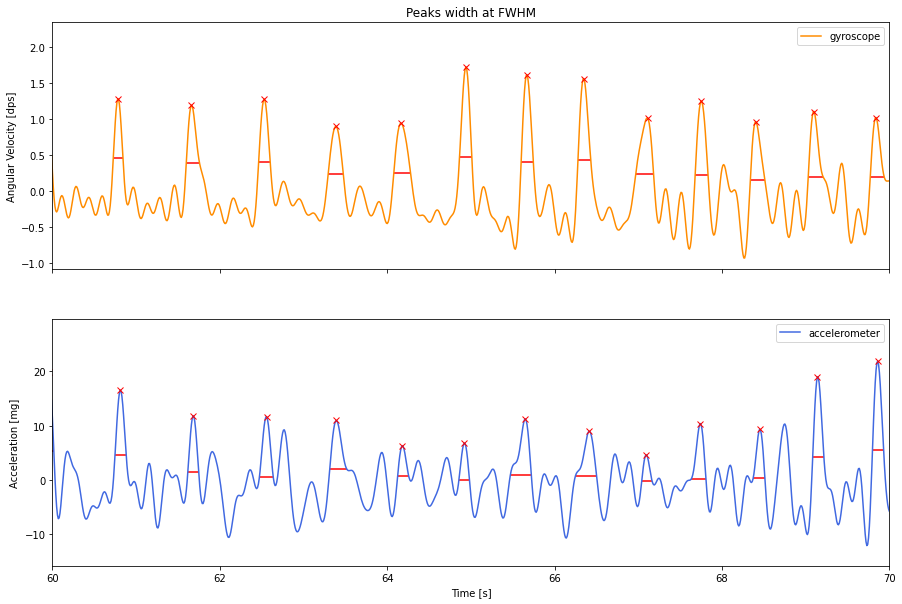

In [123]:
# gyroscope
widthsG = signal.peak_widths(signal_G, peaksG, rel_height=0.5)
# accelerometer
widthsA = signal.peak_widths(signal_A, peaks_new_A, rel_height=0.5)

fig, ax = plt.subplots(2,1, figsize=(15,10),sharex=True)
ax[0].plot(t.values,signal_G,label='gyroscope',color=colG)
ax[0].plot(t.values[peaksG], signal_G[peaksG],'rx')
ax[0].hlines(widthsG[1],xmin=1/sample_freq*widthsG[2],xmax=1/sample_freq*widthsG[3],color='red')
ax[0].set_xlim(30,40)
ax[0].set_ylabel('Angular Velocity [dps]')
ax[0].set_title('Peaks width at FWHM')
ax[0].legend()
ax[1].plot(t.values,signal_A,label='accelerometer',color=colA)
ax[1].plot(t.values[peaks_new_A], signal_A[peaks_new_A],'rx')
ax[1].hlines(widthsA[1],xmin=1/sample_freq*widthsA[2],xmax=1/sample_freq*widthsA[3],color='red')
ax[1].set_xlim(60,70)
ax[1].set_ylabel('Acceleration [mg]')
ax[1].set_xlabel('Time [s]')
ax[1].legend()

plt.show()

## Results

Finally we report the results as we did for the SCG signal:

In [124]:
xxG,fxG,rateG,err_rateG = kde_func(widthsG,t,peaksG)
xxA,fxA,rateA,err_rateA = kde_func(widthsA,t,peaks_new_A)

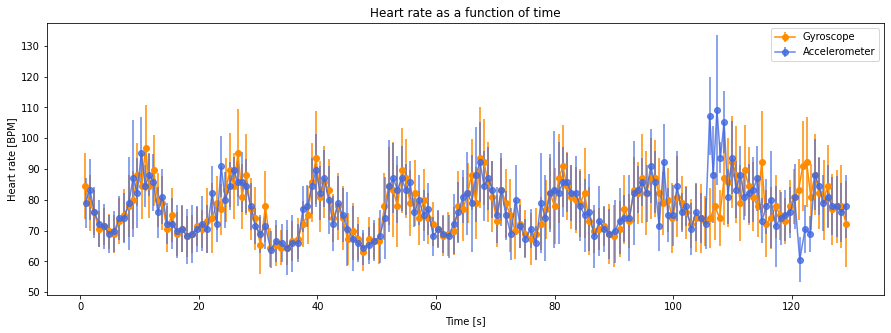

In [125]:
plt.figure(figsize=(15,5))
plt.errorbar((t.values[peaksG][1:]+t.values[peaksG][:-1])*0.5,rateG,err_rateG,marker='o',color=colG,label='Gyroscope')
plt.errorbar((t.values[peaks_new_A][1:]+t.values[peaks_new_A][:-1])*0.5,rateA,err_rateA,marker='o',color=colA,label='Accelerometer',alpha=0.8)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Heart rate [BPM]')
plt.title('Heart rate as a function of time')
plt.show()

Also in this case the heart rate oscillates during the time interval mainly between $[70,90]$ BPM. As said before, the main differences between the two signals are above $100 \; s$. Comparing with the previous analysis on the SCG signal, the oscillation of HR in time is different, in particular it displays a longer period. The difference is probably due to the fact that the subjects in the two measurements are different.

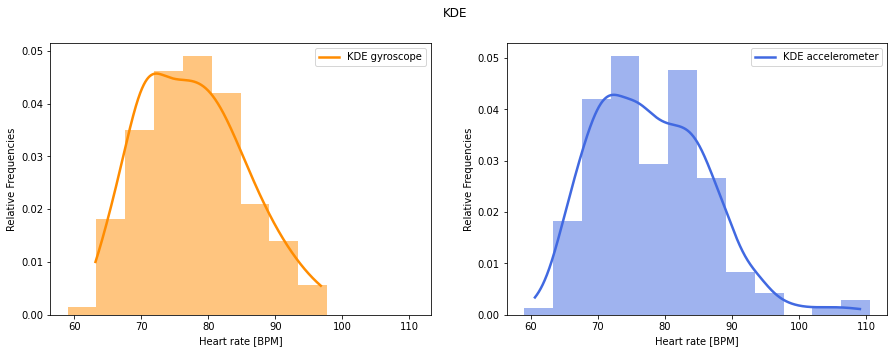

In [126]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

bins=np.arange(59,111,4.3)
ax[0].hist(rateG, bins=bins, density=True,color=colG, alpha=0.5)
ax[0].plot(xxG, fxG, linewidth=2.5, linestyle='solid',label='KDE gyroscope',color=colG)
ax[0].set_xlabel('Heart rate [BPM]')
ax[0].set_ylabel('Relative Frequencies')
ax[0].legend()
ax[1].hist(rateA, bins=bins, density=True,color=colA, alpha=0.5)
ax[1].plot(xxA, fxA, linewidth=2.5, linestyle='solid',label='KDE accelerometer',color=colA)
ax[1].set_xlabel('Heart rate [BPM]')
ax[1].set_ylabel('Relative Frequencies')
ax[1].legend()
fig.suptitle('KDE')
plt.show()

We report the weighted average as estimation of the heart rate in this interval. Despite the are some wrong peaks in the accelerometer signal, the two means are compatible with $\lambda = 1.6$.

In [127]:
#HR mean with weights
meanG = np.average(rateG, weights=1/err_rateG**2)
meanA = np.average(rateA, weights=1/err_rateA**2)
err_meanA = (1/np.sum(1/err_rateA**2))**0.5
err_meanG = (1/np.sum(1/err_rateG**2))**0.5

print('HR gyroscope: %.1f +/- %.1f BPM' %(meanG, err_meanG))
print('HR accelerometer: %.1f +/- %.1f BPM' %(meanA, err_meanA))

HR gyroscope: 74.6 +/- 0.7 BPM
HR accelerometer: 76.2 +/- 0.7 BPM


Also in this case, we estimate __heart rate variability__ with RMSSD method (Root Mean Square of Successive Differences) applied to heart beat periods.
HRV are different because the mistakes in accelerometer peak detection introduces high differences in successive periods, so accelerometer HRV is bigger.

In [128]:
#Heart rate variability
hrv_A, sigma_hrv_A = hrv(t.values,peaks_new_A,widthsA)
hrv_G, sigma_hrv_G = hrv(t.values,peaksG,widthsG)

print('Heart rate variability for accelerometer: %.0f +/- %.0f ms' %(hrv_A*1000, sigma_hrv_A*1000))
print('Heart rate variability for gyroscope: %.0f +/- %.0f ms' %(hrv_G*1000, sigma_hrv_G*1000))

Heart rate variability for accelerometer: 70 +/- 10 ms
Heart rate variability for gyroscope: 57 +/- 12 ms


Even though the compatibility between the two values is good ($\lambda = 0.8$) this is probably due to an overestimation of the peaks errors as discussed before.  

## Conclusions

To sum up, the method introduced in this notebook manages to identify the heart beat from an SGC and BCG signal. To recall it, we used PCA to select the component with the greatest variability (and less affected by the noise); then we performed a time analysis to extract the single heart beats. In order to do that, we processed the signal with a specific pipeline: 
- the discrete wavelet transform allowed us to select and keep the main peaks caused by the heart, removing high frequency noise and lower frequencies;
- the envelope helped us to highlight the peaks;
- the passband filter finally cleaned the signal we were searching for. 

At this point the signal was ready to the peaks analysis from which we estimated the heart rate and heart rate variability.
Moreover we have used a simple algorithm in order to fix the peaks estimation when the filter and the peaks detection did not work properly.

In the case of the SCG, the heart beat signal was already visible in the raw data (expecially in the gyroscope), and our procedure succeded in finding all the peaks. The final results of the two instruments matches and are compatible also with the preliminar value higlighted by the FFT of the original signals.

Concerning the BCG, the raw signals were more noisy and from the FFT we cannot find any relevant peaks within the heart beat frequency range. In this case our procedure was fundamental to extract the beat structure from the data. Nevertheless, in particular for the accelerometer, also after our filtering pipeline the signal showed some imperfections, for this reason finding peaks was more difficult. After fixing some wrong peaks with our algorithm we obtained a compatible HR with respect to the gyroscope.

Also comparing the heart rate variability of the two subjects, we have a good agreement between accelerometer and gyroscope in SCG but the two values does not match for BCG. 

To conclude, as we expected the analysis of an SCG signal brings to more reliable estimations, due to the lower noise that affect the signal (the sensor is directly placed on the sternum).  